In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#!pip install -q sentence-transformers

**LLM4IDS Multiclasse** :

Input : NSL-KDD (données tabulaires + texte)

→ Prétraitement :
    - Texte généré à partir de chaque ligne (row_to_text)
    
    - Standardisation des features numériques (StandardScaler)
    
    - Encodage du label avec LabelEncoder

→ Deux modalités :

    [1] Embeddings textuels via SentenceTransformer ("all-MiniLM-L6-v2")
    
    [2] Caractéristiques numériques (39 colonnes NSL-KDD normalisées)

→ Fusion :

    - Concatenation de X_text_emb (384 dim) + X_num (39 dim) → X_comb (423 dim)

→ Modèle :
    - Transfomer avec 200 arbre
    profondeur 6, objectif softmax
    - Apprentissage sur X_comb
    - Classification en 5 classes : ['DoS', 'Probe', 'R2L', 'U2R', 'normal']

→ Sortie :
    - Prédictions discrètes (0 à 4) converties en noms de classes
    - Évaluation : classification_report, confusion_matrix, ROC possible


In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import StandardScaler
from sentence_transformers import SentenceTransformer
import joblib
import matplotlib.pyplot as plt

In [ ]:
# 1. Colonnes NSL-KDD
columns = [
    "duration", "protocol_type", "service", "flag", "src_bytes", "dst_bytes",
    "land", "wrong_fragment", "urgent", "hot", "num_failed_logins", "logged_in",
    "num_compromised", "root_shell", "su_attempted", "num_root", "num_file_creations",
    "num_shells", "num_access_files", "num_outbound_cmds", "is_host_login", "is_guest_login",
    "count", "srv_count", "serror_rate", "srv_serror_rate", "rerror_rate", "srv_rerror_rate",
    "same_srv_rate", "diff_srv_rate", "srv_diff_host_rate", "dst_host_count",
    "dst_host_srv_count", "dst_host_same_srv_rate", "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate", "dst_host_serror_rate",
    "dst_host_srv_serror_rate", "dst_host_rerror_rate", "dst_host_srv_rerror_rate",
    "label", "difficulty"
]

# 2. Regroupement des étiquettes
attack_mapping = {
    'normal': 'normal',
    'neptune': 'DoS', 'smurf': 'DoS', 'teardrop': 'DoS', 'pod': 'DoS', 'back': 'DoS',
    'apache2': 'DoS', 'udpstorm': 'DoS', 'processtable': 'DoS', 'mailbomb': 'DoS',
    'ipsweep': 'Probe', 'portsweep': 'Probe', 'nmap': 'Probe', 'satan': 'Probe',
    'mscan': 'Probe', 'saint': 'Probe',
    'guess_passwd': 'R2L', 'ftp_write': 'R2L', 'imap': 'R2L', 'phf': 'R2L',
    'multihop': 'R2L', 'warezmaster': 'R2L', 'warezclient': 'R2L', 'spy': 'R2L',
    'sendmail': 'R2L', 'named': 'R2L', 'snmpgetattack': 'R2L', 'snmpguess': 'R2L',
    'httptunnel': 'R2L', 'xlock': 'R2L', 'xsnoop': 'R2L',
    'buffer_overflow': 'U2R', 'loadmodule': 'U2R', 'rootkit': 'U2R',
    'perl': 'U2R', 'sqlattack': 'U2R', 'xterm': 'U2R', 'ps': 'U2R', 'worm': 'U2R',
    'land': 'DoS'
}

# 3. Fonction de transformation en texte
def row_to_text(row):
    return (
        f"{row['protocol_type']} connection using {row['service']} service with {row['flag']} flag. "
        f"Sent {row['src_bytes']} bytes and received {row['dst_bytes']} bytes. "
        f"Login status: {'successful' if row['logged_in'] == 1 else 'failed'}. "
        f"{'Root access attempted.' if row['root_shell'] == 1 else ''} "
        f"Connection classified as {row['label']}."
    )

# 4. Chargement des données
df_train = pd.read_csv("https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTrain%2B.txt", header=None, names=columns)
df_test = pd.read_csv("https://raw.githubusercontent.com/defcom17/NSL_KDD/master/KDDTest%2B.txt", header=None, names=columns)

# 5. Prétraitement
for df in [df_train, df_test]:
    df['label'] = df['label'].map(attack_mapping)
    df['text'] = df.apply(row_to_text, axis=1)

# 6. Séparation des variables
X_full = df_train['text']
y_full = df_train['label']
X_test_text = df_test['text']
y_test = df_test['label'].astype(str)

X_train_text, X_val_text, y_train, y_val = train_test_split(X_full, y_full, test_size=0.2, random_state=42)

print("Dimensions des ensembles :")
print("X_train_text.shape:", X_train_text.shape)
print("X_val_text.shape  :", X_val_text.shape)
print("X_test_text.shape :", X_test_text.shape)
print("y_train.shape     :", y_train.shape)
print("y_val.shape       :", y_val.shape)
print("y_test.shape      :", y_test.shape)


Dimensions des ensembles :
X_train_text.shape: (100778,)
X_val_text.shape  : (25195,)
X_test_text.shape : (22544,)
y_train.shape     : (100778,)
y_val.shape       : (25195,)
y_test.shape      : (22544,)


In [ ]:
print("X_val_text[:5] →", X_val_text[:5])
print("y_val[:5]     →", y_val[:5])  # ← vérifie si les textes et labels correspondent


X_val_text[:5] → 378      udp connection using domain_u service with SF ...
32038    tcp connection using http service with S0 flag...
86399    tcp connection using pop_3 service with S0 fla...
74412    tcp connection using private service with REJ ...
52951    tcp connection using private service with RSTR...
Name: text, dtype: object
y_val[:5]     → 378      normal
32038       DoS
86399       DoS
74412       DoS
52951     Probe
Name: label, dtype: object


In [ ]:
row_to_text(df_train.iloc[0])

'tcp connection using ftp_data service with SF flag. Sent 491 bytes and received 0 bytes. Login status: failed.  Connection classified as normal.'

In [ ]:
df_train['label'].value_counts()

label
normal    67343
DoS       45927
Probe     11656
R2L         995
U2R          52
Name: count, dtype: int64

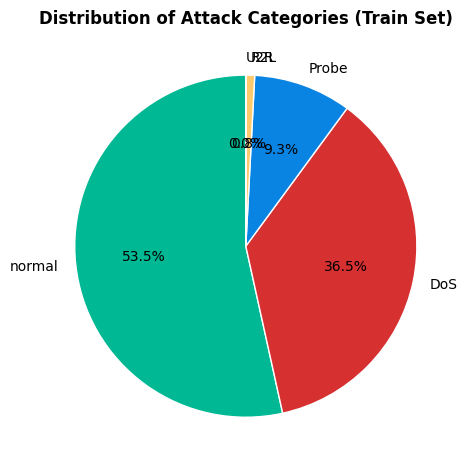

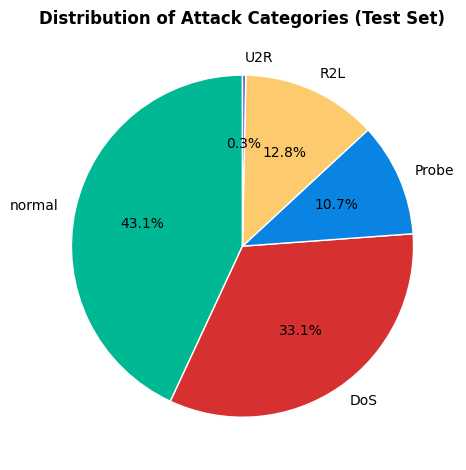

In [ ]:
import matplotlib.pyplot as plt

# Function to plot class distribution pie chart
def plot_attack_distribution(df, title):
    expected_labels = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']

    # Count occurrences, reindex to ensure all labels appear
    counts = df['label'].value_counts().reindex(expected_labels, fill_value=0)

    # Custom color palette
    colors = ['#00b894', '#d63031', '#0984e3', '#fdcb6e', '#6c5ce7']

    # Plot pie chart
    counts.plot.pie(
        autopct='%1.1f%%',
        startangle=90,
        colors=colors,
        labels=counts.index,
        wedgeprops={'edgecolor': 'white'}
    )

    plt.title(title, fontweight='bold')
    plt.ylabel("")  # Hide the y-axis label
    plt.tight_layout()
    plt.show()

# Plotting for training and testing datasets
plot_attack_distribution(df_train, "Distribution of Attack Categories (Train Set)")
plot_attack_distribution(df_test, "Distribution of Attack Categories (Test Set)")


In [ ]:
# 7. Features numériques (standardisées)
num_cols = df_train.drop(columns=['protocol_type', 'service', 'flag', 'label', 'difficulty', 'text']).columns

X_train_num = df_train.loc[X_train_text.index][num_cols].values
X_val_num = df_train.loc[X_val_text.index][num_cols].values
X_test_num = df_test[num_cols].values

scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train_num)
X_val_num = scaler.transform(X_val_num)
X_test_num = scaler.transform(X_test_num)

print("Dimensions des ensembles :")
print("X_train_num.shape:", X_train_num.shape)
print("X_val_num.shape  :", X_val_num.shape)
print("X_test_num.shape :", X_test_num.shape)

Dimensions des ensembles :
X_train_num.shape: (100778, 38)
X_val_num.shape  : (25195, 38)
X_test_num.shape : (22544, 38)


## Embeddings textuels  SentenceTransformer all-MiniLM-L6-v2

In [ ]:

# 8. Embeddings textuels  SentenceTransformer all-MiniLM-L6-v2
encoder = SentenceTransformer("all-MiniLM-L6-v2")
X_train_emb = encoder.encode(X_train_text.tolist(), show_progress_bar=True)
X_val_emb = encoder.encode(X_val_text.tolist(), show_progress_bar=True)
X_test_emb = encoder.encode(X_test_text.tolist(), show_progress_bar=True)

print("Dimensions des ensembles :")
print("X_train_emb.shape:", X_train_emb.shape)
print("X_val_emb.shape  :", X_val_emb.shape)
print("X_test_emb.shape :", X_test_emb.shape)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/3150 [00:00<?, ?it/s]

Batches:   0%|          | 0/788 [00:00<?, ?it/s]

Batches:   0%|          | 0/705 [00:00<?, ?it/s]

Dimensions des ensembles :
X_train_emb.shape: (100778, 384)
X_val_emb.shape  : (25195, 384)
X_test_emb.shape : (22544, 384)


In [ ]:
#Save data
import joblib
joblib.dump(X_train_emb, "/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_train_emb1.pkl")
joblib.dump(X_val_emb, "/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_val_emb1.pkl")
joblib.dump(X_test_emb, "/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_test_emb1.pkl")

['/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_test_emb1.pkl']

## Fusion de données

In [ ]:
#Loard data
import joblib
X_train_emb = joblib.load("/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_train_emb.pkl")
X_val_emb = joblib.load("/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_val_emb.pkl")
X_test_emb = joblib.load("/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_test_emb.pkl")


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


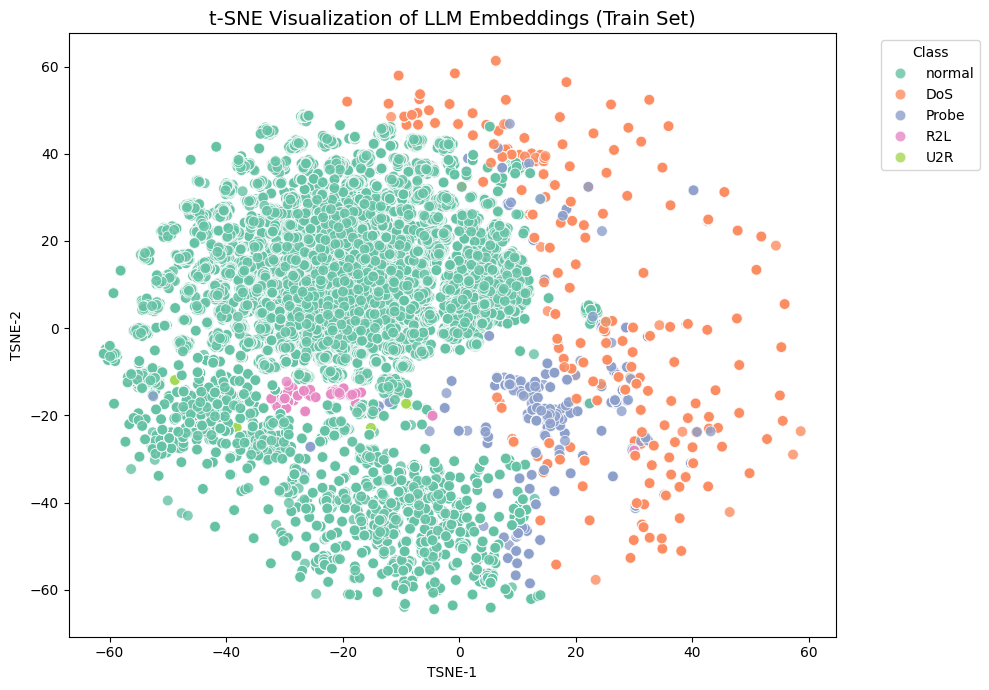

In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Load embeddings and labels
X_train_emb = joblib.load("/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_train_emb.pkl")
y_train = y_train  # Must match embeddings

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
X_train_2D = tsne.fit_transform(X_train_emb)

# Convert to DataFrame for plotting
import pandas as pd
df_vis = pd.DataFrame(X_train_2D, columns=["TSNE-1", "TSNE-2"])
df_vis["Label"] = y_train.values if hasattr(y_train, 'values') else y_train

# Plot with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_vis, x="TSNE-1", y="TSNE-2", hue="Label", palette="Set2", alpha=0.8, s=60)
plt.title("t-SNE Visualization of LLM Embeddings (Train Set)", fontsize=14)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


/usr/local/lib/python3.11/dist-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


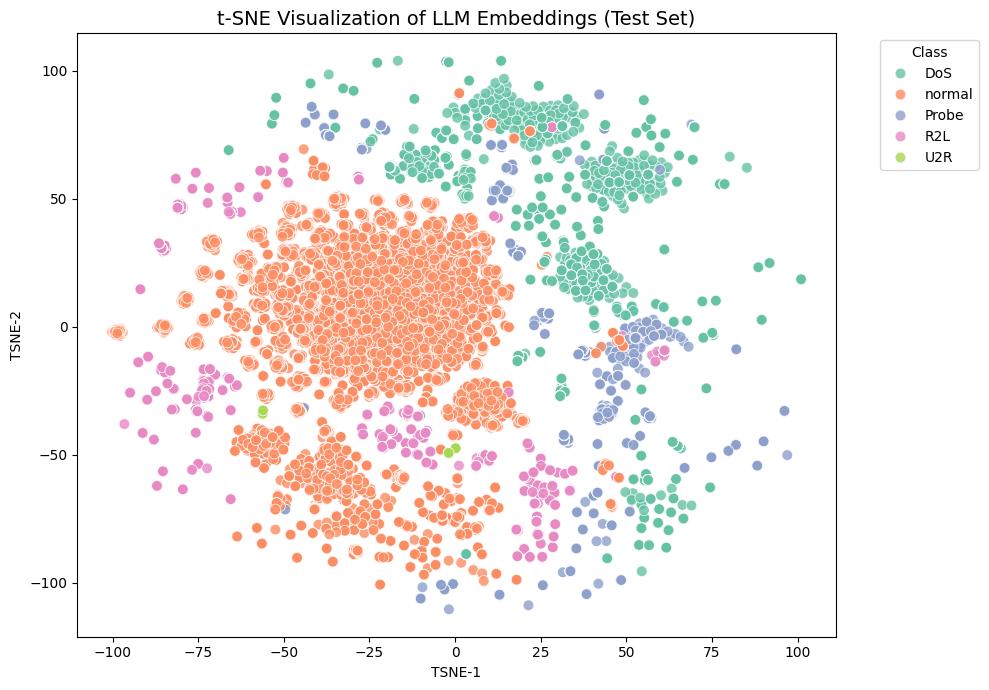

In [ ]:
import joblib
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import seaborn as sns

# Load embeddings and labels
X_test_emb = joblib.load("/content/drive/MyDrive/SAINT-IDS/NSL-KDD/Data/X_test_emb.pkl")
y_test = y_test # Must match embeddings

# Apply t-SNE to reduce to 2D
tsne = TSNE(n_components=2, random_state=42, perplexity=30, learning_rate=200, n_iter=1000)
X_test_2D = tsne.fit_transform(X_test_emb)

# Convert to DataFrame for plotting
import pandas as pd
df_vis = pd.DataFrame(X_test_2D, columns=["TSNE-1", "TSNE-2"])
df_vis["Label"] = y_test.values if hasattr(y_test, 'values') else y_test

# Plot with Seaborn
plt.figure(figsize=(10, 7))
sns.scatterplot(data=df_vis, x="TSNE-1", y="TSNE-2", hue="Label", palette="Set2", alpha=0.8, s=60)
plt.title("t-SNE Visualization of LLM Embeddings (Test Set)", fontsize=14)
plt.legend(title="Class", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [ ]:
# 9. Fusion des deux modalités
X_train_comb = np.concatenate([X_train_emb, X_train_num], axis=1)
X_val_comb = np.concatenate([X_val_emb, X_val_num], axis=1)
X_test_comb = np.concatenate([X_test_emb, X_test_num], axis=1)

print("Dimensions des ensembles :")
print("X_train_comb.shape:", X_train_comb.shape)
print("X_val_comb.shape  :", X_val_comb.shape)
print("X_test_comb.shape :", X_test_comb.shape)

Dimensions des ensembles :
X_train_comb.shape: (100778, 422)
X_val_comb.shape  : (25195, 422)
X_test_comb.shape : (22544, 422)


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

# Encodage des étiquettes (str -> int -> one-hot)
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))


## Visualisation

In [ ]:
# Affichage du shape (utile pour valider one-hot)
print("Dimensions :")
print("y_train_enc.shape:", y_train_enc.shape)
print("y_val_enc.shape  :", y_val_enc.shape)
print("y_test_enc.shape :", y_test_enc.shape)

# Affichage d'un extrait du contenu (premières lignes)
print("\n Extrait de y_train_enc :")
print(y_train_enc[:5])

print("\nExtrait de y_val_enc :")
print(y_val_enc[:5])

print("\n Extrait de y_test_enc :")
print(y_test_enc[:5])


Dimensions :
y_train_enc.shape: (100778, 5)
y_val_enc.shape  : (25195, 5)
y_test_enc.shape : (22544, 5)

 Extrait de y_train_enc :
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1.]]

Extrait de y_val_enc :
[[0. 0. 0. 0. 1.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]

 Extrait de y_test_enc :
[[1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1.]
 [0. 1. 0. 0. 0.]
 [0. 1. 0. 0. 0.]]


In [ ]:
# Dimensions
print("Dimensions des ensembles combinés :")
print("X_train_comb.shape :", X_train_comb.shape)
print("X_val_comb.shape   :", X_val_comb.shape)
print("X_test_comb.shape  :", X_test_comb.shape)

# Extraits de contenu (5 premières lignes)
print("\n Aperçu de X_train_comb :")
print(X_train_comb[:5])

print("\n Aperçu de X_val_comb :")
print(X_val_comb[:5])

print("\n Aperçu de X_test_comb :")
print(X_test_comb[:5])


Dimensions des ensembles combinés :
X_train_comb.shape : (100778, 422)
X_val_comb.shape   : (25195, 422)
X_test_comb.shape  : (22544, 422)

 Aperçu de X_train_comb :
[[ 0.04774705  0.02845133 -0.07263345 ... -0.62456242 -0.38818079
  -0.37701233]
 [ 0.0106408   0.0750773  -0.06859829 ...  1.61966297 -0.38818079
  -0.37701233]
 [-0.01138185  0.06646867 -0.05805036 ... -0.62456242  2.87103311
   2.75150662]
 [ 0.03912073  0.03031219 -0.05857965 ... -0.62456242 -0.38818079
  -0.37701233]
 [ 0.05475503  0.00597934  0.00394313 ... -0.62456242 -0.38818079
  -0.37701233]]

 Aperçu de X_val_comb :
[[ 5.01634143e-02  8.38729832e-03  2.29264231e-04 ... -6.24562415e-01
  -3.88180790e-01 -3.77012331e-01]
 [ 1.32306097e-02  6.98085725e-02 -8.30790401e-02 ...  1.61966297e+00
  -3.88180790e-01 -3.77012331e-01]
 [-1.18489591e-02  1.39859039e-02 -6.01353683e-02 ...  1.61966297e+00
  -3.88180790e-01 -3.77012331e-01]
 [-1.26847634e-02  6.67062327e-02 -5.39549813e-02 ... -6.24562415e-01
   2.87103311e+00 

## **Fonctiob E valuation**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_curve, roc_auc_score
)
from sklearn.preprocessing import label_binarize

def eval_model_unv(model, X_test, y_test, le=None, model_name="Model"):
    """
    Évaluation universelle pour modèles Scikit-learn et Keras (multiclasse).
    Gère : y_test encodé (int), one-hot ou texte ; modèles avec predict ou predict_proba.
    """

    # 1. Gestion de y_test one-hot → int
    if len(y_test.shape) > 1 and y_test.shape[1] > 1:
        y_test = np.argmax(y_test, axis=1)

    # 2. Prédiction des scores
    try:
        y_score = model.predict_proba(X_test)
    except AttributeError:
        y_score = model.predict(X_test)

    # 3. Si y_score est 1D ou shape ≠ nb_classes → classif direct
    if len(y_score.shape) == 1 or y_score.shape[1] == 1:
        y_pred = (y_score > 0.5).astype(int)
    else:
        y_pred = np.argmax(y_score, axis=1)

    # 4. Gestion du LabelEncoder (optionnel)
    if le is not None:
        if isinstance(y_test[0], str):
            y_test_labels = y_test
            y_test_int = le.transform(y_test)
        else:
            y_test_int = y_test
            y_test_labels = le.inverse_transform(y_test)

        if isinstance(y_pred[0], str):
            y_pred_labels = y_pred
            y_pred_int = le.transform(y_pred)
        else:
            y_pred_int = y_pred
            y_pred_labels = le.inverse_transform(y_pred)

        class_names = le.classes_
    else:
        y_test_int = y_test
        y_pred_int = y_pred
        y_test_labels = y_test
        y_pred_labels = y_pred
        class_names = np.unique(y_test)

    # 5. Rapport de classification
    print(f"\n Rapport de classification - {model_name}")
    print(classification_report(y_test_labels, y_pred_labels, target_names=class_names))

    # 6. Matrice de confusion
    cm = confusion_matrix(y_test_labels, y_pred_labels, labels=class_names)
    plt.figure(figsize=(7, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"Matrice de confusion - {model_name}")
    plt.xlabel("Prédit")
    plt.ylabel("Réel")
    plt.tight_layout()
    plt.show()

    # 7. TPR / FPR
    print("\n TPR (Recall) et FPR par classe :")
    for i, name in enumerate(class_names):
        TP = cm[i, i]
        FN = np.sum(cm[i, :]) - TP
        FP = np.sum(cm[:, i]) - TP
        TN = np.sum(cm) - (TP + FN + FP)
        TPR = TP / (TP + FN) if (TP + FN) > 0 else 0.0
        FPR = FP / (FP + TN) if (FP + TN) > 0 else 0.0
        print(f"  {name:<20} → TPR = {TPR:.2f} | FPR = {FPR:.2f}")

    # 8. ROC One-vs-All
    if len(np.unique(y_test_int)) > 2 and y_score.shape[1] == len(class_names):
        y_bin = label_binarize(y_test_int, classes=np.arange(len(class_names)))

        plt.figure(figsize=(8, 6))
        for i, name in enumerate(class_names):
            if np.sum(y_bin[:, i]) == 0:
                print(f"Classe '{name}' absente de y_true → ROC ignoré.")
                continue
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc = roc_auc_score(y_bin[:, i], y_score[:, i])
            plt.plot(fpr, tpr, label=f"{name} (AUC = {auc:.2f})")

        plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
        plt.title(f"Courbes ROC One-vs-All - {model_name}")
        plt.xlabel("Faux positifs (FPR)")
        plt.ylabel("Vrais positifs (TPR)")
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        print("ROC non générée (binaire ou score incompatible).")
#evaluate_model(model=mlp_clf, X_test=X_test_comb, y_test=y_test, le=le, model_name="MLPClassifier")
#evaluate_model(model=cnn_model, X_test=X_test_cnn, y_test=y_test_enc, le=le, model_name="CNN")


**Modelisation**

## **1. LLM4IDS Transformer**

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models

def create_dense_transformer_multiclass(input_dim, num_classes):
    inputs = tf.keras.Input(shape=(1, input_dim))

    # Dense projection
    x = layers.Dense(256)(inputs)
    x = layers.LayerNormalization()(x)

    # Attention multi-têtes
    attn = layers.MultiHeadAttention(num_heads=4, key_dim=64)
    x_attn = attn(x, x)
    x = layers.Add()([x, x_attn])
    x = layers.LayerNormalization()(x)

    # Feedforward
    x = layers.Dense(128, activation='relu')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(64, activation='relu')(x)
    outputs = layers.Dense(num_classes, activation='softmax')(x)

    return models.Model(inputs, outputs)


In [ ]:
# Préparation des données
X_train_tf = np.expand_dims(X_train_comb, axis=1)
X_val_tf = np.expand_dims(X_val_comb, axis=1)
X_test_tf = np.expand_dims(X_test_comb, axis=1)


Epoch 1/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9810 - auc: 0.9979 - loss: 0.0585 - precision: 0.9871 - recall: 0.9749

3150/3150 ━━━━━━━━━━━━━━━━━━━━ 133s 40ms/step - accuracy: 0.9810 - auc: 0.9979 - loss: 0.0585 - precision: 0.9871 - recall: 0.9749 - val_accuracy: 0.9990 - val_auc: 1.0000 - val_loss: 0.0021 - val_precision: 0.9993 - val_recall: 0.9987
Epoch 2/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 178s 51ms/step - accuracy: 0.9985 - auc: 0.9999 - loss: 0.0042 - precision: 0.9987 - recall: 0.9985 - val_accuracy: 0.9993 - val_auc: 0.9999 - val_loss: 0.0037 - val_precision: 0.9993 - val_recall: 0.9993
Epoch 3/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 126s 40ms/step - accuracy: 0.9987 - auc: 0.9999 - loss: 0.0043 - precision: 0.9988 - recall: 0.9987 - val_accuracy: 0.9967 - val_auc: 0.9990 - val_loss: 0.0179 - val_precision: 0.9968 - val_recall: 0.9967
Epoch 4/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 174s 50ms/step - accuracy: 0.9991 - auc: 0.9999 - loss: 0.0029 - precision: 0.9991 - recall: 0.9991 - val_accuracy: 0.9991 - val_auc: 1.0000 - val_loss: 0.0025 - val_precision: 0.9993 - val_recall: 0.9990
Epoch 5/20
3150/3150 ━━

3150/3150 ━━━━━━━━━━━━━━━━━━━━ 149s 39ms/step - accuracy: 0.9994 - auc: 1.0000 - loss: 0.0021 - precision: 0.9994 - recall: 0.9994 - val_accuracy: 0.9995 - val_auc: 1.0000 - val_loss: 0.0014 - val_precision: 0.9995 - val_recall: 0.9995
Epoch 7/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 124s 39ms/step - accuracy: 0.9996 - auc: 1.0000 - loss: 9.7677e-04 - precision: 0.9997 - recall: 0.9996 - val_accuracy: 0.9995 - val_auc: 0.9999 - val_loss: 0.0019 - val_precision: 0.9995 - val_recall: 0.9994
Epoch 8/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 144s 40ms/step - accuracy: 0.9997 - auc: 1.0000 - loss: 0.0012 - precision: 0.9997 - recall: 0.9997 - val_accuracy: 0.9994 - val_auc: 0.9998 - val_loss: 0.0029 - val_precision: 0.9995 - val_recall: 0.9994
Epoch 9/20
3150/3150 ━━━━━━━━━━━━━━━━━━━━ 114s 36ms/step - accuracy: 0.9998 - auc: 1.0000 - loss: 8.3308e-04 - precision: 0.9998 - recall: 0.9998 - val_accuracy: 0.9998 - val_auc: 0.9999 - val_loss: 0.0021 - val_precision: 0.9998 - val_recall: 0.9998
Epoch 10/20
315

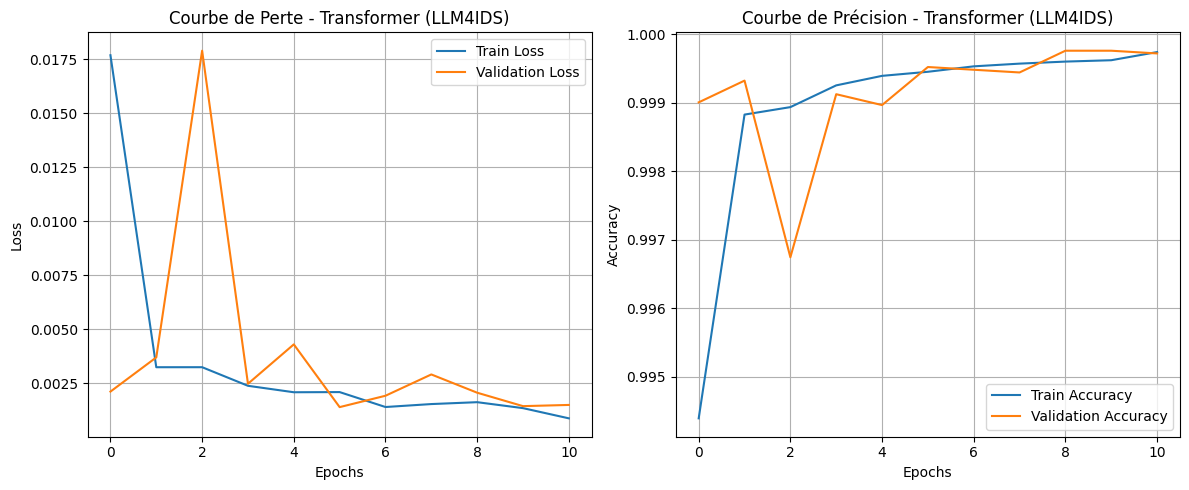

In [ ]:

# Modèle
model = create_dense_transformer_multiclass(X_train_comb.shape[1], num_classes=5)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003), loss='categorical_crossentropy', metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')])

# Callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint("transformer_multiclass_nslkdd.h5", save_best_only=True)
]

# Entraînement
hist_llm4ids = model.fit(
    X_train_tf, y_train_enc,
    validation_data=(X_val_tf, y_val_enc),
    epochs=20,
    batch_size=32,
    callbacks=callbacks
)
# --------- Courbes d'apprentissage ---------
plt.figure(figsize=(12, 5))

# Courbe de la perte (Loss)
plt.subplot(1, 2, 1)
plt.plot(hist_llm4ids.history.get('loss', []), label='Train Loss')
plt.plot(hist_llm4ids.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Perte - Transformer (LLM4IDS)')
plt.legend()
plt.grid(True)

# Courbe de la précision (Accuracy)
plt.subplot(1, 2, 2)
plt.plot(hist_llm4ids.history.get('accuracy', []), label='Train Accuracy')
plt.plot(hist_llm4ids.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Courbe de Précision - Transformer (LLM4IDS)")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
#model.save_weights("LLM4-IDS/nsl-kdd/models/llm4ids_multiclass_nslkdd_weights.h5")
model.save("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/llm4ids_multiclass_nslkdd2.h5")
model.save("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/llm4ids_multiclass_nslkdd2.keras")

In [ ]:
# Évaluation sur le test set
# Capture all metrics returned by model.evaluate()
test_results = model.evaluate(X_test_tf, y_test_enc)

# The metrics are returned in the order they were compiled.
# Assuming the order is ['loss', 'accuracy', 'precision', 'recall', 'auc']
# Access the accuracy by index (usually the second metric) or by name if available
test_loss = test_results[0]
test_acc = test_results[1] # Assuming accuracy is the second metric

print(f"Transformer Test Accuracy: {test_acc:.4f}")

# Prédictions
y_pred = model.predict(X_test_tf)
y_pred_labels = le.inverse_transform(np.argmax(y_pred, axis=1))

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred_labels))

705/705 ━━━━━━━━━━━━━━━━━━━━ 4s 6ms/step - accuracy: 0.9956 - auc: 0.9986 - loss: 0.0395 - precision: 0.9957 - recall: 0.9955
Transformer Test Accuracy: 0.9947
705/705 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7458
       Probe       1.00      1.00      1.00      2421
         R2L       1.00      0.99      1.00      2885
         U2R       0.77      0.67      0.71        69
      normal       0.99      1.00      0.99      9711

    accuracy                           0.99     22544
   macro avg       0.95      0.93      0.94     22544
weighted avg       0.99      0.99      0.99     22544



705/705 ━━━━━━━━━━━━━━━━━━━━ 6s 8ms/step

 Rapport de classification - LLM4IDS
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      7458
       Probe       1.00      1.00      1.00      2421
         R2L       1.00      0.99      1.00      2885
         U2R       0.77      0.67      0.71        69
      normal       0.99      1.00      0.99      9711

    accuracy                           0.99     22544
   macro avg       0.95      0.93      0.94     22544
weighted avg       0.99      0.99      0.99     22544



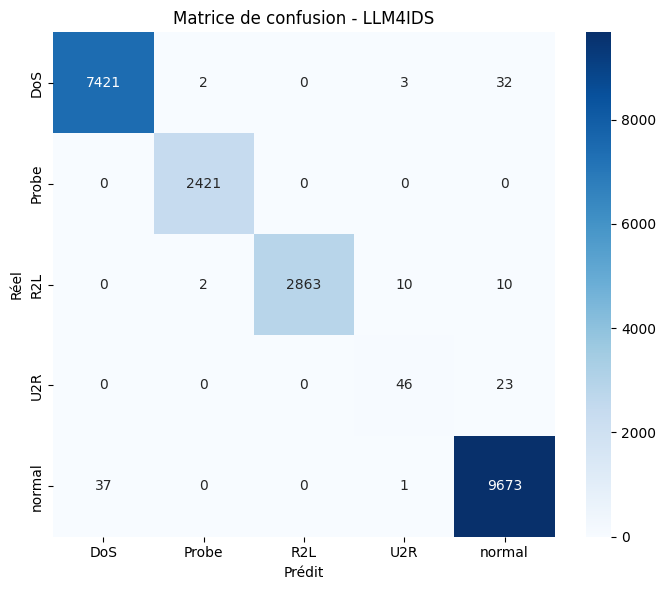


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 1.00 | FPR = 0.00
  Probe                → TPR = 1.00 | FPR = 0.00
  R2L                  → TPR = 0.99 | FPR = 0.00
  U2R                  → TPR = 0.67 | FPR = 0.00
  normal               → TPR = 1.00 | FPR = 0.01


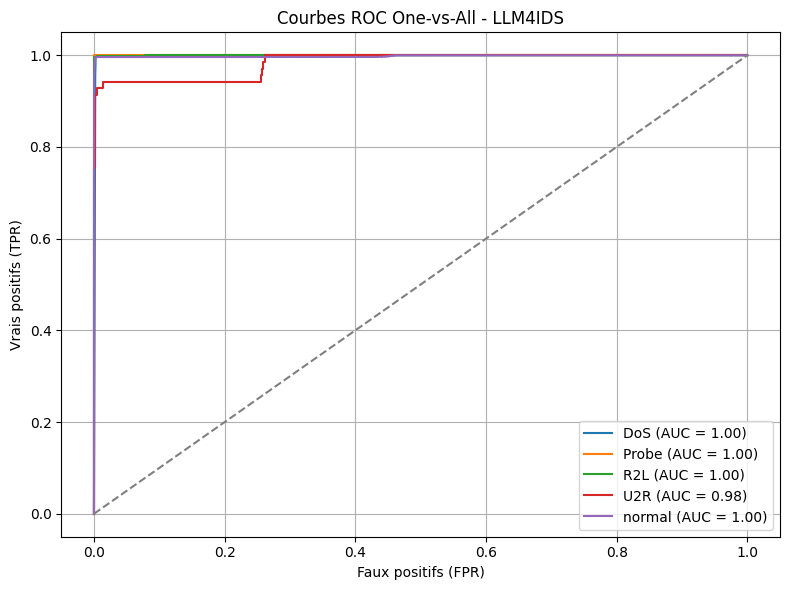

In [ ]:
from tensorflow.keras.models import load_model

#llm4ids_model = load_model("LLM4-IDS/nsl-kdd/models/llm4ids_multiclass_nslkdd.keras")
llm4ids_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/llm4ids_multiclass_nslkdd2.h5")

eval_model_unv(model=llm4ids_model, X_test=X_test_tf, y_test=y_test_enc, le=le, model_name="LLM4IDS")


## **2. MLP Classifer**

In [ ]:
from sklearn.neural_network import MLPClassifier

# 1. Entraînement
mlp_clf = MLPClassifier(
    hidden_layer_sizes=(256, 128),
    max_iter=300,
    activation='relu',
    solver='adam',
    random_state=42
)
mlp_clf.fit(X_train_comb, y_train)

# 2. Évaluation
print("Validation set (MLP)")
print(classification_report(y_val, mlp_clf.predict(X_val_comb)))

print("Test set (KDDTest+)")
print(classification_report(y_test, mlp_clf.predict(X_test_comb)))


Validation set (MLP)
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9181
       Probe       1.00      1.00      1.00      2357
         R2L       1.00      1.00      1.00       224
         U2R       1.00      1.00      1.00        11
      normal       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195

Test set (KDDTest+)
              precision    recall  f1-score   support

         DoS       0.98      1.00      0.99      7458
       Probe       0.99      0.97      0.98      2421
         R2L       1.00      0.96      0.98      2885
         U2R       0.94      0.67      0.78        69
      normal       0.98      0.99      0.99      9711

    accuracy                           0.99     22544
   macro avg       0.98      0.92      0.94     22544
weighted avg       0.99      0.99   


 Rapport de classification - MLPClassifier
              precision    recall  f1-score   support

         DoS       0.98      1.00      0.99      7458
       Probe       0.99      0.97      0.98      2421
         R2L       1.00      0.96      0.98      2885
         U2R       0.94      0.67      0.78        69
      normal       0.98      0.99      0.99      9711

    accuracy                           0.99     22544
   macro avg       0.98      0.92      0.94     22544
weighted avg       0.99      0.99      0.99     22544



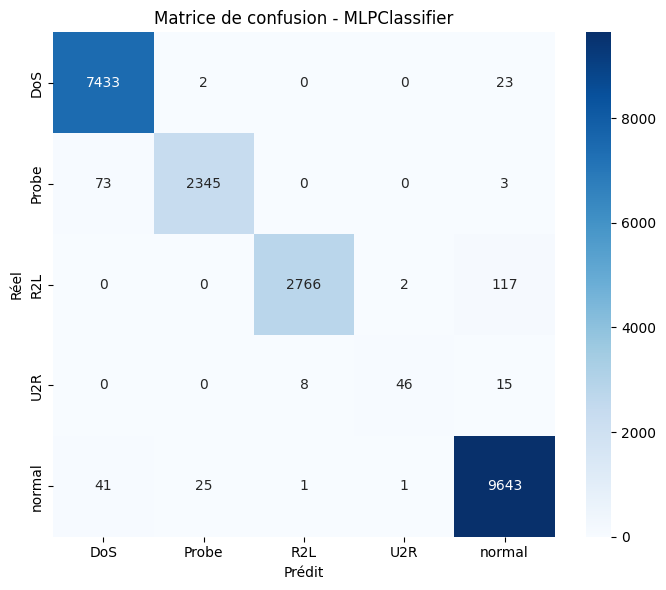


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 1.00 | FPR = 0.01
  Probe                → TPR = 0.97 | FPR = 0.00
  R2L                  → TPR = 0.96 | FPR = 0.00
  U2R                  → TPR = 0.67 | FPR = 0.00
  normal               → TPR = 0.99 | FPR = 0.01


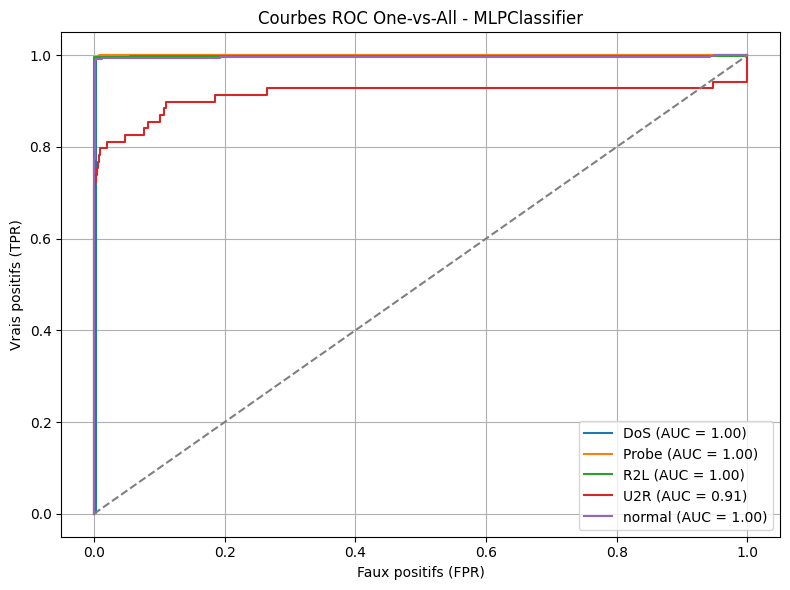

In [ ]:
mlp_clf = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/mlp_sklearn_llm4ids.pkl")
eval_model_unv(model=mlp_clf, X_test=X_test_comb, y_test=y_test, le=le, model_name="MLPClassifier")


## **3. CNN**

In [ ]:
# Entrée : vecteurs combinés reshaped
input_dim = X_train_comb.shape[1]
X_train_cnn = X_train_comb.reshape(-1, input_dim, 1)
X_val_cnn   = X_val_comb.reshape(-1, input_dim, 1)
X_test_cnn  = X_test_comb.reshape(-1, input_dim, 1)


Epoch 1/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 150s 187ms/step - accuracy: 0.8984 - loss: 0.4339 - val_accuracy: 0.8339 - val_loss: 0.5192 - learning_rate: 0.0010
Epoch 2/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 145s 184ms/step - accuracy: 0.9891 - loss: 0.0476 - val_accuracy: 0.9883 - val_loss: 0.0416 - learning_rate: 0.0010
Epoch 3/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 145s 183ms/step - accuracy: 0.9927 - loss: 0.0329 - val_accuracy: 0.9916 - val_loss: 0.0306 - learning_rate: 0.0010
Epoch 4/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 147s 186ms/step - accuracy: 0.9958 - loss: 0.0230 - val_accuracy: 0.6508 - val_loss: 1.1529 - learning_rate: 0.0010
Epoch 5/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 144s 183ms/step - accuracy: 0.9957 - loss: 0.0206 - val_accuracy: 0.9959 - val_loss: 0.0216 - learning_rate: 0.0010
Epoch 6/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 141s 179ms/step - accuracy: 0.9968 - loss: 0.0161 - val_accuracy: 0.9967 - val_loss: 0.0181 - learning_rate: 0.0010
Epoch 7/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 138s 175ms/step -

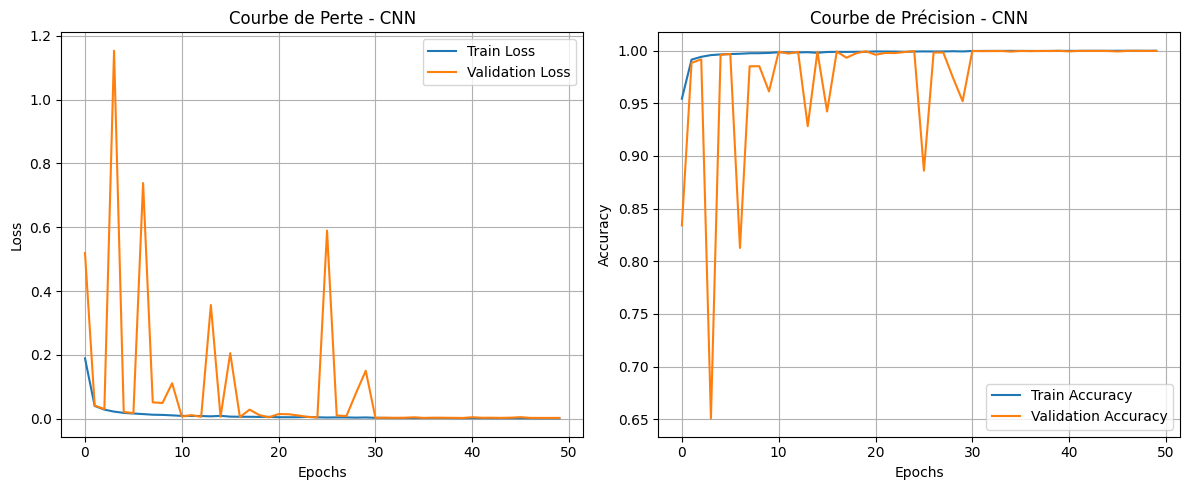

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Architecture CNN 1D améliorée
cnn_model = models.Sequential([
    layers.Input(shape=(input_dim, 1)),

    layers.Conv1D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.4),

    layers.Conv1D(128, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv1D(64, 3, padding="same", activation="relu"),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),

    layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    layers.Dropout(0.4),

    layers.Dense(y_train_enc.shape[1], activation='softmax')
])

cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=Adam(learning_rate=1e-3),
    metrics=['accuracy']
)

# Callbacks
callbacks = [
    EarlyStopping(patience=10, monitor="val_loss", restore_best_weights=True),
    ReduceLROnPlateau(patience=5, factor=0.5, min_lr=1e-6)
]

# Entraînement
cnn_h = cnn_model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=100,
    batch_size=128,
    callbacks=callbacks,
    verbose=1
)
# --------- Courbes d'apprentissage ---------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 1. Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(cnn_h.history.get('loss', []), label='Train Loss')
plt.plot(cnn_h.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Perte - CNN')
plt.legend()
plt.grid(True)

# 2. Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(cnn_h.history.get('accuracy', []), label='Train Accuracy')
plt.plot(cnn_h.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Courbe de Précision - CNN")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


705/705 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step

 Rapport de classification - CNN
              precision    recall  f1-score   support

         DoS       0.98      0.97      0.98      7458
       Probe       0.99      0.93      0.96      2421
         R2L       1.00      0.82      0.90      2885
         U2R       1.00      0.83      0.90        69
      normal       0.93      1.00      0.96      9711

    accuracy                           0.96     22544
   macro avg       0.98      0.91      0.94     22544
weighted avg       0.96      0.96      0.96     22544



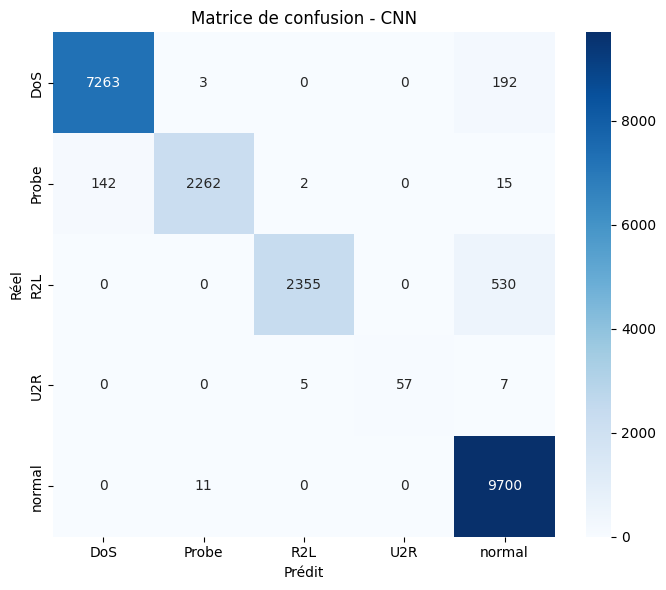


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.97 | FPR = 0.01
  Probe                → TPR = 0.93 | FPR = 0.00
  R2L                  → TPR = 0.82 | FPR = 0.00
  U2R                  → TPR = 0.83 | FPR = 0.00
  normal               → TPR = 1.00 | FPR = 0.06


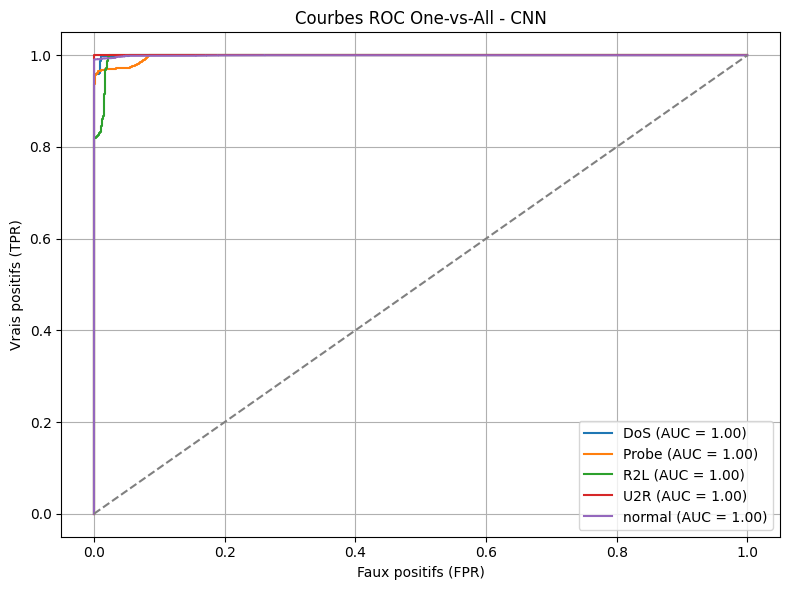

In [ ]:
#Save model
cnn_model.save("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/cnn_multiclass.keras")

#Loard keras
from tensorflow.keras.models import load_model
cnn_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/cnn_multiclass.keras")
eval_model_unv(model=cnn_model, X_test=X_test_cnn, y_test=y_test_enc, le=le, model_name="CNN")

In [ ]:
from tensorflow.keras import models, layers, regularizers
from tensorflow.keras.optimizers import Adam
import tensorflow as tf # Add this line

# Dimensions d'entrée
input_dim = X_train_comb.shape[1]

# Architecture CNN 1D pour données tabulaires
cnn_model = models.Sequential([
    layers.Input(shape=(input_dim, 1)),  # Reshape préalable nécessaire
    layers.Conv1D(filters=64, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),

    layers.Conv1D(filters=128, kernel_size=3, activation='relu', padding='same'),
    layers.BatchNormalization(),
    layers.GlobalAveragePooling1D(),

    layers.Dense(64, activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(y_train_enc.shape[1], activation='softmax')
])

# Compilation
cnn_model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
cnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d_2 (Conv1D)               │ (None, 422, 64)        │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 422, 64)        │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 422, 64)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 422, 128)       │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 422, 128)       │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d_1      │ (None, 128)            │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,309 (134.02 KB)

 Trainable params: 33,925 (132.52 KB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
X_train_cnn = np.expand_dims(X_train_comb, axis=2)
X_val_cnn   = np.expand_dims(X_val_comb, axis=2)
X_test_cnn  = np.expand_dims(X_test_comb, axis=2)


Epoch 1/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 353s 443ms/step - accuracy: 0.8567 - auc: 0.9573 - loss: 0.7196 - precision: 0.8940 - recall: 0.5605 - val_accuracy: 0.4544 - val_auc: 0.6276 - val_loss: 3.6919 - val_precision: 0.4561 - val_recall: 0.4543
Epoch 2/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 334s 424ms/step - accuracy: 0.9684 - auc: 0.9983 - loss: 0.1081 - precision: 0.9734 - recall: 0.9642 - val_accuracy: 0.4537 - val_auc: 0.6419 - val_loss: 6.3649 - val_precision: 0.4537 - val_recall: 0.4537
Epoch 3/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 331s 420ms/step - accuracy: 0.9816 - auc: 0.9995 - loss: 0.0597 - precision: 0.9852 - recall: 0.9786 - val_accuracy: 0.4574 - val_auc: 0.6487 - val_loss: 6.0577 - val_precision: 0.4575 - val_recall: 0.4574
Epoch 4/50
788/788 ━━━━━━━━━━━━━━━━━━━━ 378s 416ms/step - accuracy: 0.9888 - auc: 0.9997 - loss: 0.0386 - precision: 0.9904 - recall: 0.9866 - val_accuracy: 0.6531 - val_auc: 0.9210 - val_loss: 0.9635 - val_precision: 0.6672 - val_recall: 0.6273
Epoch 5/50
788/7

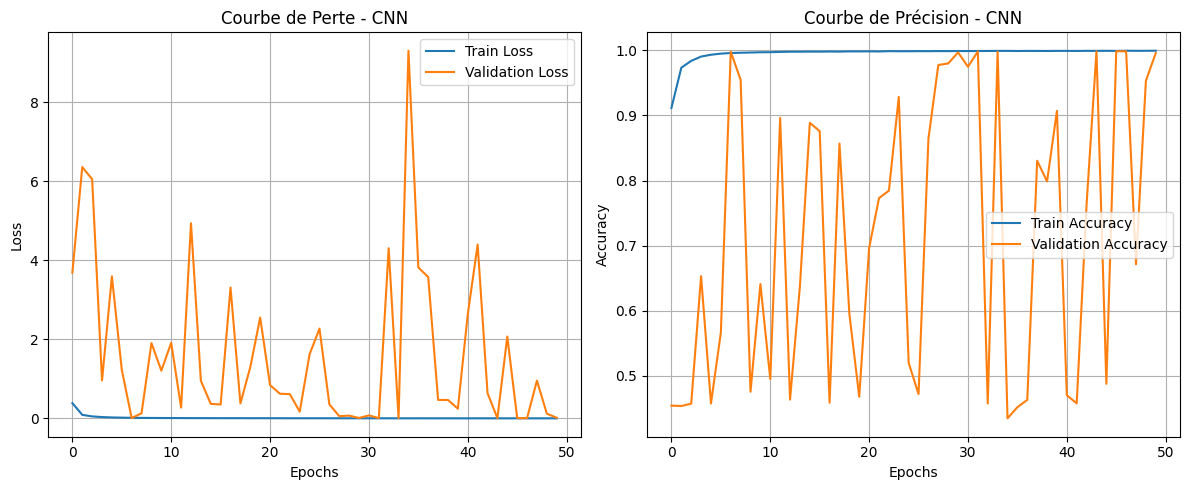

In [ ]:
# Exemple : entraînement
from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_callback = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    verbose=1,
    min_lr=1e-6
)
cnn_h = cnn_model.fit(
    X_train_cnn, y_train_enc,
    validation_data=(X_val_cnn, y_val_enc),
    epochs=50,
    batch_size=128,
    verbose=1
)
# --------- Courbes d'apprentissage ---------
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

# 1. Courbe de perte
plt.subplot(1, 2, 1)
plt.plot(cnn_h.history.get('loss', []), label='Train Loss')
plt.plot(cnn_h.history.get('val_loss', []), label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Courbe de Perte - CNN')
plt.legend()
plt.grid(True)

# 2. Courbe de précision
plt.subplot(1, 2, 2)
plt.plot(cnn_h.history.get('accuracy', []), label='Train Accuracy')
plt.plot(cnn_h.history.get('val_accuracy', []), label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title("Courbe de Précision - CNN")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


705/705 ━━━━━━━━━━━━━━━━━━━━ 14s 20ms/step

 Rapport de classification - CNN
              precision    recall  f1-score   support

         DoS       0.98      0.95      0.97      7458
       Probe       0.55      0.97      0.70      2421
         R2L       0.99      0.48      0.65      2885
         U2R       1.00      0.09      0.16        69
      normal       0.97      0.96      0.96      9711

    accuracy                           0.89     22544
   macro avg       0.90      0.69      0.69     22544
weighted avg       0.93      0.89      0.89     22544



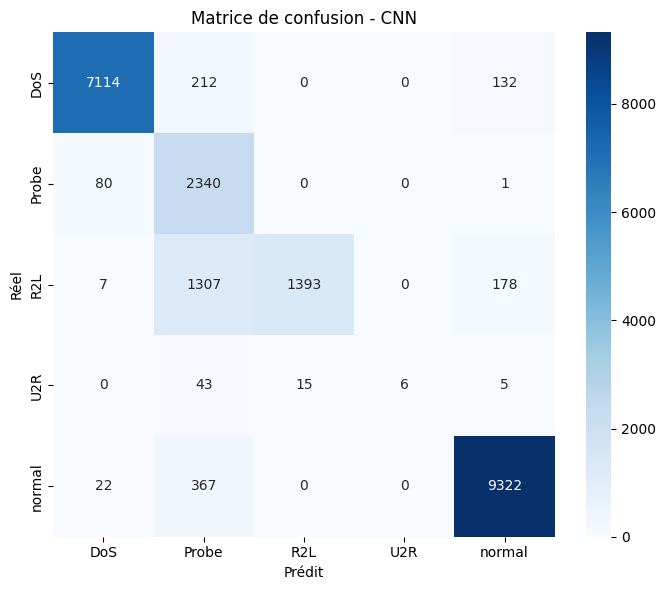


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.95 | FPR = 0.01
  Probe                → TPR = 0.97 | FPR = 0.10
  R2L                  → TPR = 0.48 | FPR = 0.00
  U2R                  → TPR = 0.09 | FPR = 0.00
  normal               → TPR = 0.96 | FPR = 0.02


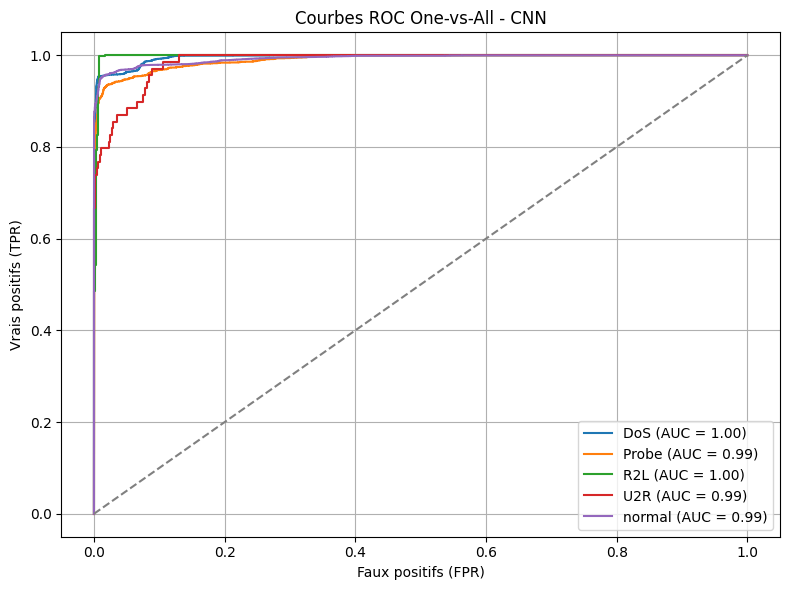

In [ ]:
#Save keras
cnn_model.save("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/cnn_multiclass.keras")

#Loard keras
from tensorflow.keras.models import load_model
#cnn_model = load_model("LLM4-IDS/nsl-kdd/models/cnn_multiclass.keras")
cnn_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/cnn_multiclass.keras")

eval_model_unv(model=cnn_model, X_test=X_test_cnn, y_test=y_test_enc, le=le, model_name="CNN")

## GRU

In [ ]:
  # Reshape for GRU
X_train = np.expand_dims(X_train_comb, axis=1)
X_val = np.expand_dims(X_val_comb, axis=1)
X_test_r  = np.expand_dims(X_test_comb, axis=1)

Epoch 1/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 36s 119ms/step - accuracy: 0.7962 - auc: 0.9330 - loss: 1.9339 - precision: 0.8368 - recall: 0.7681 - val_accuracy: 0.9724 - val_auc: 0.9993 - val_loss: 0.8749 - val_precision: 0.9862 - val_recall: 0.9618 - learning_rate: 3.0000e-04
Epoch 2/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 21s 107ms/step - accuracy: 0.9825 - auc: 0.9989 - loss: 0.7214 - precision: 0.9852 - recall: 0.9798 - val_accuracy: 0.9945 - val_auc: 0.9999 - val_loss: 0.5295 - val_precision: 0.9950 - val_recall: 0.9942 - learning_rate: 3.0000e-04
Epoch 3/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 37s 85ms/step - accuracy: 0.9908 - auc: 0.9995 - loss: 0.5127 - precision: 0.9921 - recall: 0.9899 - val_accuracy: 0.9978 - val_auc: 0.9998 - val_loss: 0.4105 - val_precision: 0.9979 - val_recall: 0.9978 - learning_rate: 3.0000e-04
Epoch 4/100
197/197 ━━━━━━━━━━━━━━━━━━━━ 29s 128ms/step - accuracy: 0.9938 - auc: 0.9996 - loss: 0.4016 - precision: 0.9943 - recall: 0.9933 - val_accuracy: 0.9988 - val_auc: 0.99

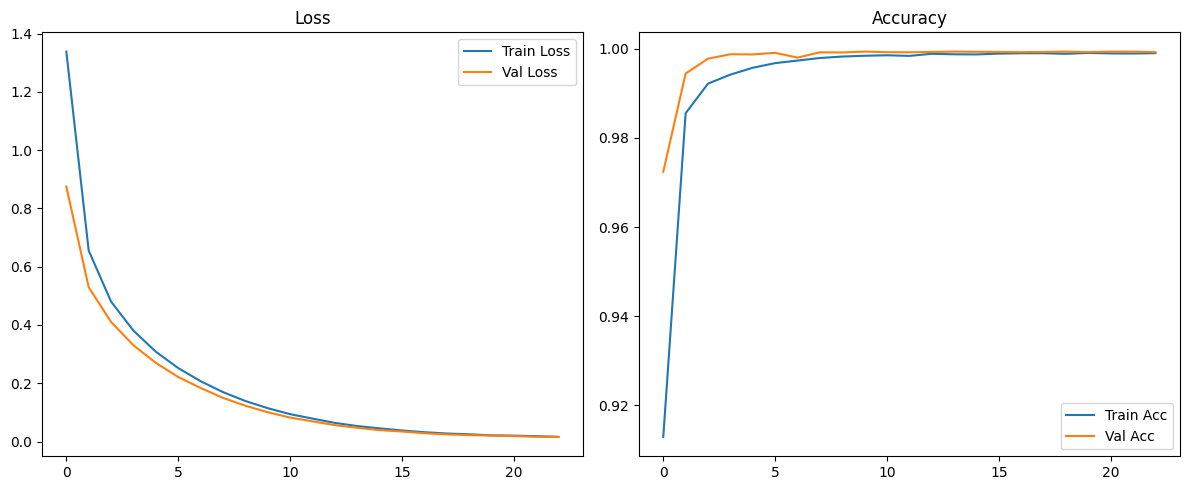

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers, callbacks
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, mutual_info_classif
from sklearn.metrics import classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns

  # Reshape for GRU
X_train = np.expand_dims(X_train_comb, axis=1)
X_val = np.expand_dims(X_val_comb, axis=1)
X_test  = np.expand_dims(X_test_comb, axis=1)

# ===== 2. ENHANCED MODEL ARCHITECTURE =====
def build_enhanced_model(input_shape, num_classes):
    gru = models.Sequential([
        layers.Input(shape=input_shape),
        layers.Bidirectional(layers.GRU(160, return_sequences=True,
                                      kernel_regularizer=regularizers.l2(0.001))),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Bidirectional(layers.GRU(80,
                                      kernel_regularizer=regularizers.l2(0.001))),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(80, activation='relu',
                   kernel_regularizer=regularizers.l2(0.001)),
        layers.Dropout(0.4),
        layers.Dense(num_classes, activation='softmax') # Use num_classes here
    ])

    gru.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0003),
        loss='categorical_crossentropy',
        metrics=['accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall'),
                tf.keras.metrics.AUC(name='auc')]
    )
    return gru

# Use the number of classes from y_train_enc
num_classes = y_train_enc.shape[1]
gru = build_enhanced_model((1, X_train.shape[2]), num_classes)

#model = build_enhanced_model((1, X_train.shape[2]))
# Enhanced callbacks
callbacks = [
    callbacks.EarlyStopping(patience=8, monitor='val_auc',
                          mode='max', restore_best_weights=True),
    callbacks.ReduceLROnPlateau(factor=0.5, patience=4, min_lr=1e-6),
    callbacks.ModelCheckpoint('best_model.keras', monitor='val_auc',
                            save_best_only=True, mode='max')
]

history = gru.fit(
    X_train, y_train_enc, # Use y_train_enc here
    validation_data=(X_val, y_val_enc), # Use y_val_enc here
    epochs=100,  # Increased epochs
    batch_size=512,  # Larger batch size
    callbacks=callbacks,
    verbose=1
)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history.get('loss', []), label="Train Loss")
plt.plot(history.history.get('val_loss', []), label="Val Loss")
plt.legend(), plt.title("Loss")

plt.subplot(1, 2, 2)
plt.plot(history.history.get('accuracy', []), label="Train Acc")
plt.plot(history.history.get('val_accuracy', []), label="Val Acc")
plt.legend(), plt.title("Accuracy")
plt.tight_layout()
plt.show()

705/705 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step

 Rapport de classification - GRU
              precision    recall  f1-score   support

         DoS       0.98      1.00      0.99      7458
       Probe       0.83      1.00      0.91      2421
         R2L       0.99      0.62      0.77      2885
         U2R       1.00      0.03      0.06        69
      normal       0.94      0.99      0.97      9711

    accuracy                           0.94     22544
   macro avg       0.95      0.73      0.74     22544
weighted avg       0.95      0.94      0.94     22544



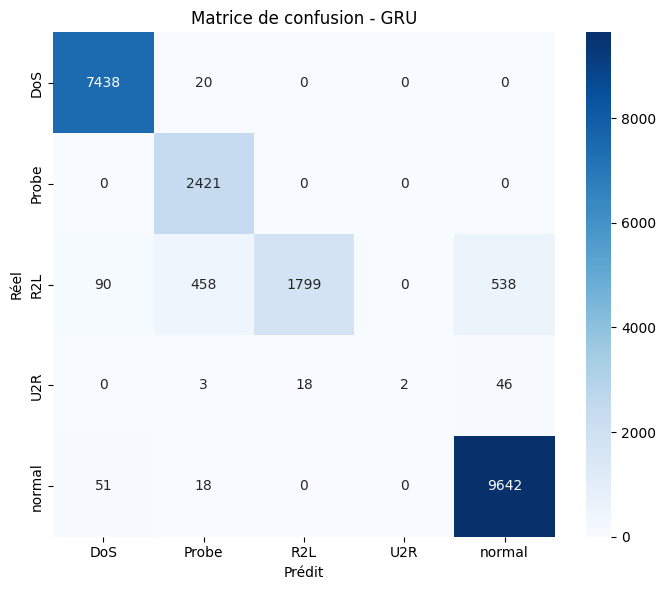


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 1.00 | FPR = 0.01
  Probe                → TPR = 1.00 | FPR = 0.02
  R2L                  → TPR = 0.62 | FPR = 0.00
  U2R                  → TPR = 0.03 | FPR = 0.00
  normal               → TPR = 0.99 | FPR = 0.05


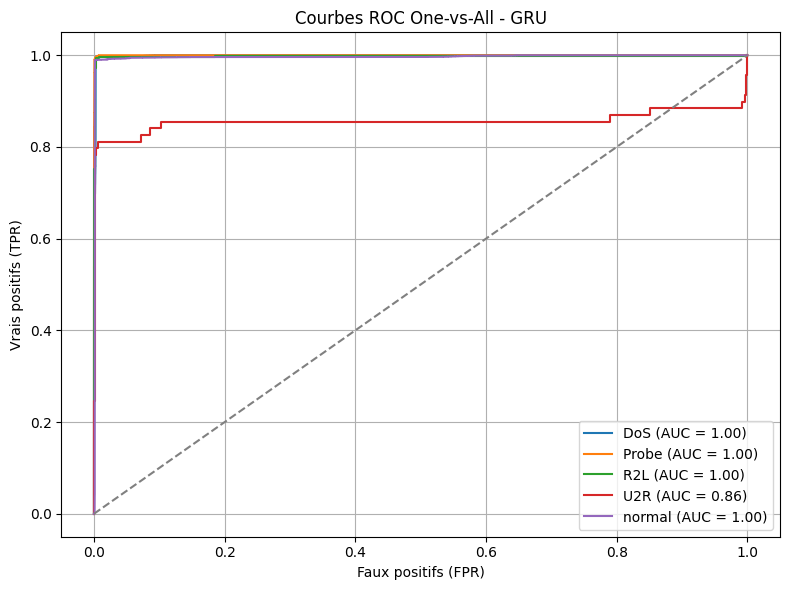

In [ ]:
#Save model keras
gru.save("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/gru_multiclass.keras")

#Loard keras
from tensorflow.keras.models import load_model
gru = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/gru_multiclass.keras")

eval_model_unv(model=gru, X_test=X_test, y_test=y_test_enc, le=le, model_name="GRU")

## **3. Random Forest**

In [ ]:
# Import necessary libraries
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline # Import Pipeline from imblearn
import time  # Importer le module time
# Ensure imblearn is installed
try:
    from imblearn.over_sampling import ADASYN
except ImportError:
    print("imblearn not found. Installing...")
    !pip install imbalanced-learn
    from imblearn.over_sampling import ADASYN

# Define the pipeline using imblearn's Pipeline
# This allows the inclusion of sampling steps like ADASYN
pipeline = Pipeline([
    ('adasyn', ADASYN(random_state=42)),
    ('classifier', RandomForestClassifier(random_state=42))
])

param_dist = {
    'classifier__n_estimators': [100, 200, 300],
    'classifier__max_depth': [None, 10, 20, 30],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__bootstrap': [True, False],
    'adasyn__n_neighbors': [3, 5, 7], # adasyn params are correctly specified here
}

rf_model = RandomizedSearchCV(
    estimator=pipeline,
    param_distributions=param_dist,
    n_iter=10, # Number of parameter settings that are sampled. Lower for faster run.
    cv=3,     # Number of folds in cross-validation
    verbose=2,
    n_jobs=-1, # Use all available CPU cores
    # Consider using a metric more appropriate for imbalanced data
    # like 'f1', 'recall', or 'roc_auc' instead of 'accuracy'
    scoring='roc_auc',
    random_state=42
)
start = time.time()
# Fit the model using the correct imblearn pipeline
rf_model.fit(X_train_comb, y_train)
finish = time.time()

t = finish - start

print("Best params:", rf_model.best_params_)
print("Best CV Score:", rf_model.best_score_)
print("Best Test Score:", rf_model.score(X_val_comb, y_val_enc))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


/usr/local/lib/python3.11/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(


Best params: {'classifier__n_estimators': 300, 'classifier__min_samples_split': 5, 'classifier__min_samples_leaf': 2, 'classifier__max_depth': 30, 'classifier__bootstrap': False, 'adasyn__n_neighbors': 7}
Best CV Score: nan
Best Test Score: 0.9999999670921913


In [ ]:
#Save model
import joblib
import os
save_dir = "/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models"
os.makedirs(save_dir, exist_ok=True)
rf_model_filename = "random_forest_llm4ids.pkl"
rf_model_path = os.path.join(save_dir, rf_model_filename)
joblib.dump
(rf_model.best_estimator_, rf_model_path)
print(f"Modèle Random Forest sauvegardé dans : {rf_model_path}")


Modèle Random Forest sauvegardé dans : /content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl



 Rapport de classification - Random Forest
              precision    recall  f1-score   support

         DoS       1.00      0.90      0.95      7458
       Probe       0.98      1.00      0.99      2421
         R2L       1.00      0.51      0.68      2885
         U2R       1.00      1.00      1.00        69
      normal       0.82      1.00      0.90      9711

    accuracy                           0.90     22544
   macro avg       0.96      0.88      0.90     22544
weighted avg       0.92      0.90      0.90     22544



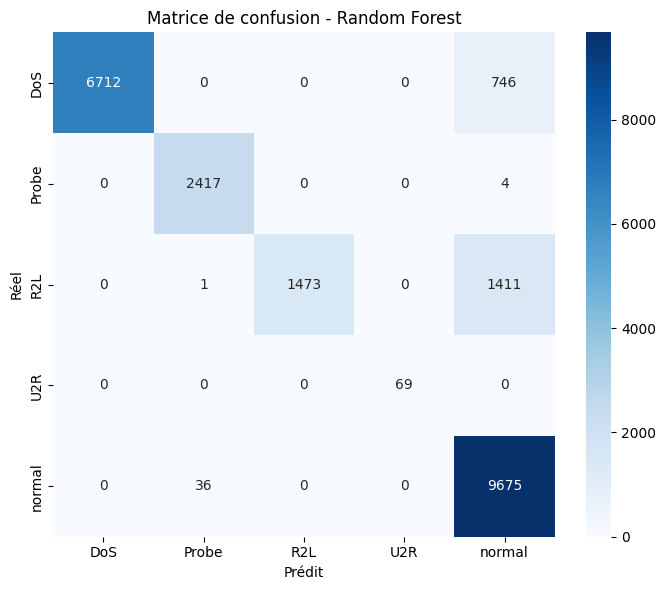


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.90 | FPR = 0.00
  Probe                → TPR = 1.00 | FPR = 0.00
  R2L                  → TPR = 0.51 | FPR = 0.00
  U2R                  → TPR = 1.00 | FPR = 0.00
  normal               → TPR = 1.00 | FPR = 0.17


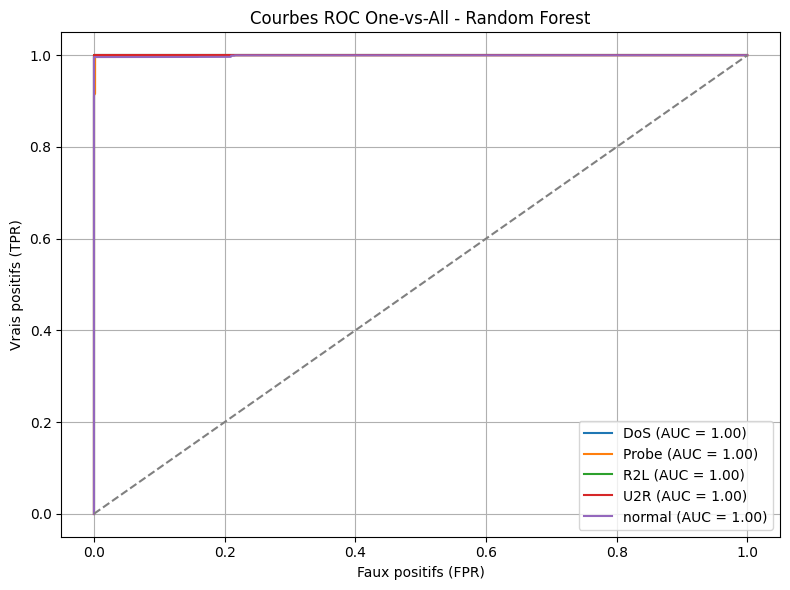

In [ ]:
#Loard rf
from sklearn.ensemble import RandomForestClassifier
import joblib
rf_loaded = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl")
eval_model_unv(model=rf_loaded, X_test=X_test_comb, y_test=y_test, le=le, model_name="Random Forest")


In [ ]:
from sklearn.ensemble import RandomForestClassifier

# 9. Entraînement Random Forest
rf_clf = RandomForestClassifier(n_estimators=200, class_weight="balanced", random_state=42)
rf_clf.fit(X_train_comb, y_train)


# 11. Évaluation
print(" Validation set (KDDTrain+)")
print(classification_report(y_val.astype(str), rf_clf.predict(X_val_comb).astype(str)))


 Validation set (KDDTrain+)
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9181
       Probe       1.00      1.00      1.00      2357
         R2L       1.00      1.00      1.00       224
         U2R       1.00      1.00      1.00        11
      normal       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [ ]:
#Save model rf_clf LLM4-IDS/nsl-kdd/models/
import joblib
import os
save_dir = "/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models"
os.makedirs(save_dir, exist_ok=True)
rf_clf_filename = "random_forest_llm4ids.pkl"
rf_clf_path = os.path.join(save_dir, rf_clf_filename)
joblib.dump(rf_clf, rf_clf_path)
print(f"Modèle Random Forest sauvegardé dans : {rf_clf_path}")



 Rapport de classification - Random Forest
              precision    recall  f1-score   support

         DoS       1.00      0.90      0.95      7458
       Probe       0.98      1.00      0.99      2421
         R2L       1.00      0.51      0.68      2885
         U2R       1.00      1.00      1.00        69
      normal       0.82      1.00      0.90      9711

    accuracy                           0.90     22544
   macro avg       0.96      0.88      0.90     22544
weighted avg       0.92      0.90      0.90     22544



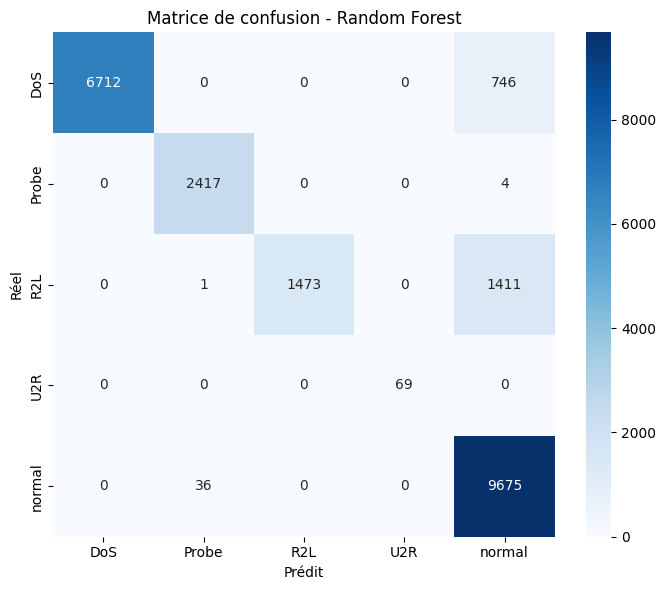


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.90 | FPR = 0.00
  Probe                → TPR = 1.00 | FPR = 0.00
  R2L                  → TPR = 0.51 | FPR = 0.00
  U2R                  → TPR = 1.00 | FPR = 0.00
  normal               → TPR = 1.00 | FPR = 0.17


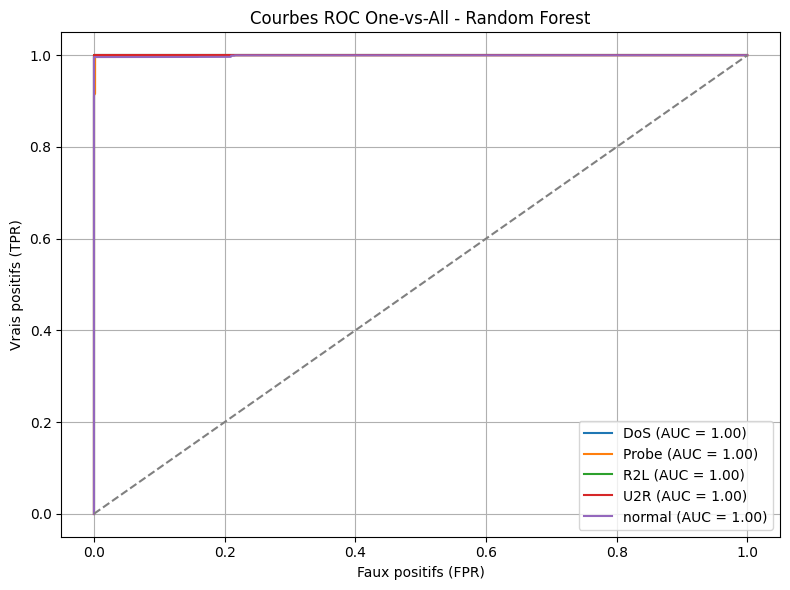

In [ ]:

#loard model
from sklearn.ensemble import RandomForestClassifier
import joblib
rf_loaded = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl")

eval_model_unv(model=rf_loaded, X_test=X_test_comb, y_test=y_test, le=le, model_name="Random Forest")

## **4. XGBoost**

In [ ]:
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sentence_transformers import SentenceTransformer
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt


# 12. Entraînement XGBoost
xgb_clf = XGBClassifier(
    objective="multi:softmax",
    num_class=len(le.classes_), # Use the number of unique classes from the LabelEncoder
    eval_metric="mlogloss",
    use_label_encoder=False,
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42
)

# Fit with integer labels
xgb_clf.fit(X_train_comb, le.transform(y_train))

# 13. Évaluation
print("\n Validation set (KDDTrain+)")
y_val_pred = xgb_clf.predict(X_val_comb)
print(classification_report(y_val, le.inverse_transform(y_val_pred), target_names=le.classes_))


 Validation set (KDDTrain+)
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9181
       Probe       1.00      1.00      1.00      2357
         R2L       1.00      1.00      1.00       224
         U2R       1.00      1.00      1.00        11
      normal       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       1.00      1.00      1.00     25195
weighted avg       1.00      1.00      1.00     25195



In [ ]:
# 12. Sau
# 3. Sauvegarde
import joblib
import os

# === Dossier de sauvegarde
save_dir = "/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models"
os.makedirs(save_dir, exist_ok=True)

# === Nom du fichier du modèle
xgb_filename = "xgb_llm4ids_model.pkl"
xgb_path = os.path.join(save_dir, xgb_filename)

# === Sauvegarde
joblib.dump(xgb_clf, xgb_path)
print(f"Modèle XGBoost sauvegardé dans : {xgb_path}")
joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))


Modèle XGBoost sauvegardé dans : LLM4-IDS/nsl-kdd/models/xgb_llm4ids_model.pkl


['LLM4-IDS/nsl-kdd/models/label_encoder.pkl']


 Rapport de classification - XGBoost
              precision    recall  f1-score   support

         DoS       1.00      0.99      0.99      7458
       Probe       0.99      1.00      0.99      2421
         R2L       1.00      0.51      0.68      2885
         U2R       1.00      1.00      1.00        69
      normal       0.86      1.00      0.93      9711

    accuracy                           0.93     22544
   macro avg       0.97      0.90      0.92     22544
weighted avg       0.94      0.93      0.92     22544



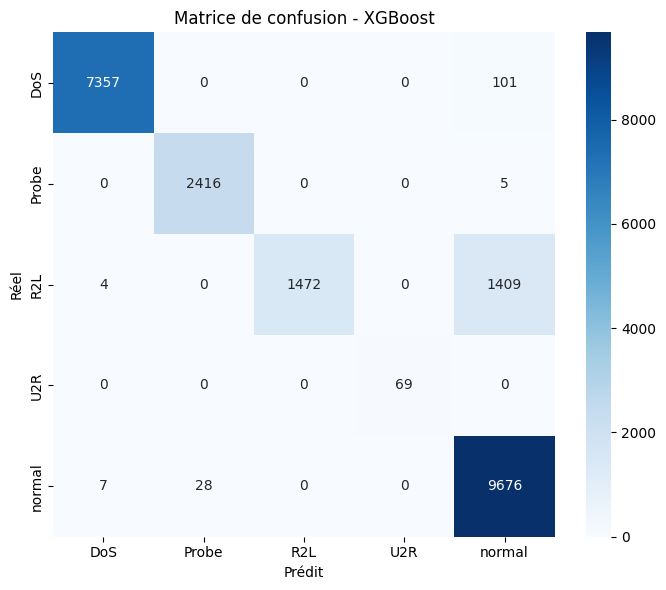


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.99 | FPR = 0.00
  Probe                → TPR = 1.00 | FPR = 0.00
  R2L                  → TPR = 0.51 | FPR = 0.00
  U2R                  → TPR = 1.00 | FPR = 0.00
  normal               → TPR = 1.00 | FPR = 0.12


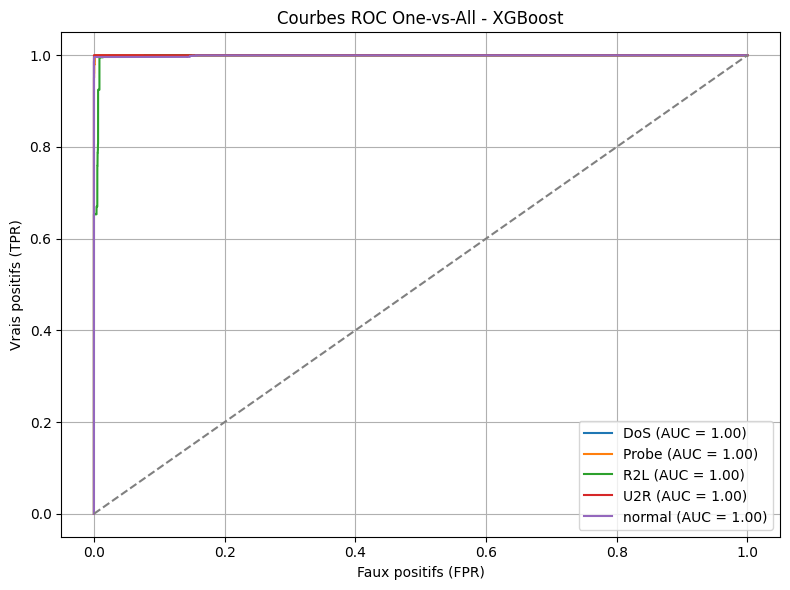

In [ ]:
from xgboost import XGBClassifier
import joblib

# === Chargement
xgb_model = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/xgb_llm4ids_model.pkl")
le = joblib.load(os.path.join(save_dir, "label_encoder.pkl"))

# === Prédiction
eval_model_unv(model=xgb_model, X_test=X_test_comb, y_test=y_test, le=le, model_name="XGBoost")


## 5. Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression
# 10. Entraînement LogisticRegression (multiclasse)
lr_clf = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')
lr_clf.fit(X_train_comb, y_train)

# 11. Évaluation
print(" Validation set (KDDTrain+)")
print(classification_report(y_val.astype(str), lr_clf.predict(X_val_comb).astype(str)))


 Validation set (KDDTrain+)
              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00      9181
       Probe       1.00      1.00      1.00      2357
         R2L       0.99      1.00      0.99       224
         U2R       0.86      0.55      0.67        11
      normal       1.00      1.00      1.00     13422

    accuracy                           1.00     25195
   macro avg       0.97      0.91      0.93     25195
weighted avg       1.00      1.00      1.00     25195




 Rapport de classification - Logistic Regression
              precision    recall  f1-score   support

         DoS       0.99      0.93      0.96      7458
       Probe       0.99      0.98      0.98      2421
         R2L       1.00      0.49      0.66      2885
         U2R       0.85      0.33      0.48        69
      normal       0.83      0.99      0.90      9711

    accuracy                           0.90     22544
   macro avg       0.93      0.75      0.80     22544
weighted avg       0.92      0.90      0.90     22544



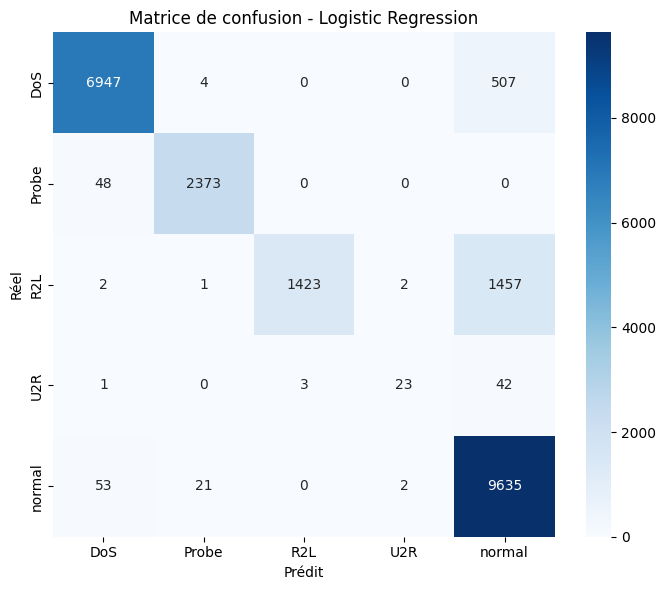


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.93 | FPR = 0.01
  Probe                → TPR = 0.98 | FPR = 0.00
  R2L                  → TPR = 0.49 | FPR = 0.00
  U2R                  → TPR = 0.33 | FPR = 0.00
  normal               → TPR = 0.99 | FPR = 0.16


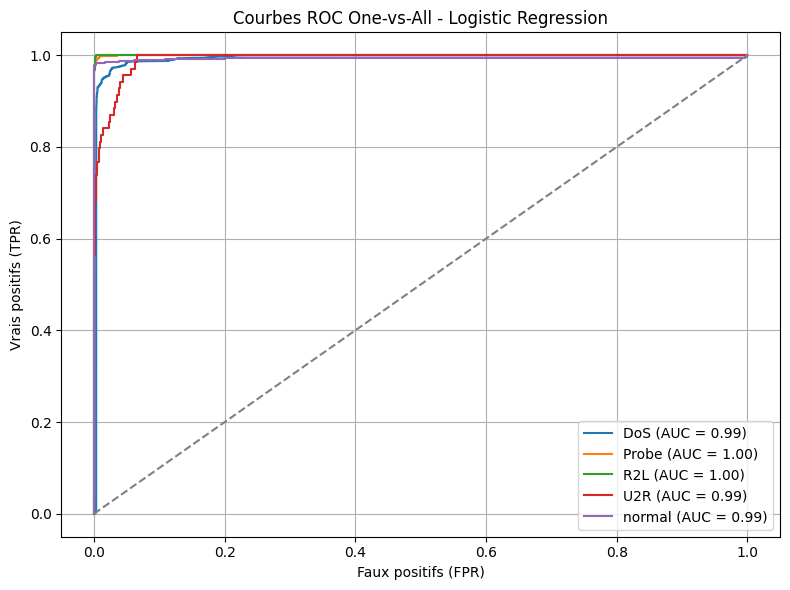

In [ ]:
eval_model_unv(model=lr_clf, X_test=X_test_comb, y_test=y_test, le=le, model_name="Logistic Regression")

In [ ]:
import os
import joblib

# === Dossier de sauvegarde
save_dir = "/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models"
os.makedirs(save_dir, exist_ok=True)

# === Nom du fichier
lr_model_filename = "logistic_regression_llm4ids.pkl"
lr_model_path = os.path.join(save_dir, lr_model_filename)

# === Sauvegarde du modèle
joblib.dump(lr_clf, lr_model_path)
print(f" Modèle Logistic Regression sauvegardé dans : {lr_model_path}")
joblib.dump(le, os.path.join(save_dir, "label_encoder.pkl"))


 Modèle Logistic Regression sauvegardé dans : LLM4-IDS/nsl-kdd/models/logistic_regression_llm4ids.pkl


['LLM4-IDS/nsl-kdd/models/label_encoder.pkl']

In [ ]:
from sklearn.linear_model import LogisticRegression
import joblib

# === Chargement
lr_clf = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/logistic_regression_llm4ids.pkl")
le = joblib.load(os.path.join(save_dir, "label_encoder.pkl"))

# === Utilisation
y_pred = lr_clf.predict(X_test_comb)



 Rapport de classification - Logistic Regression
              precision    recall  f1-score   support

         DoS       0.99      0.93      0.96      7458
       Probe       0.99      0.98      0.98      2421
         R2L       1.00      0.49      0.66      2885
         U2R       0.85      0.33      0.48        69
      normal       0.83      0.99      0.90      9711

    accuracy                           0.90     22544
   macro avg       0.93      0.75      0.80     22544
weighted avg       0.92      0.90      0.90     22544



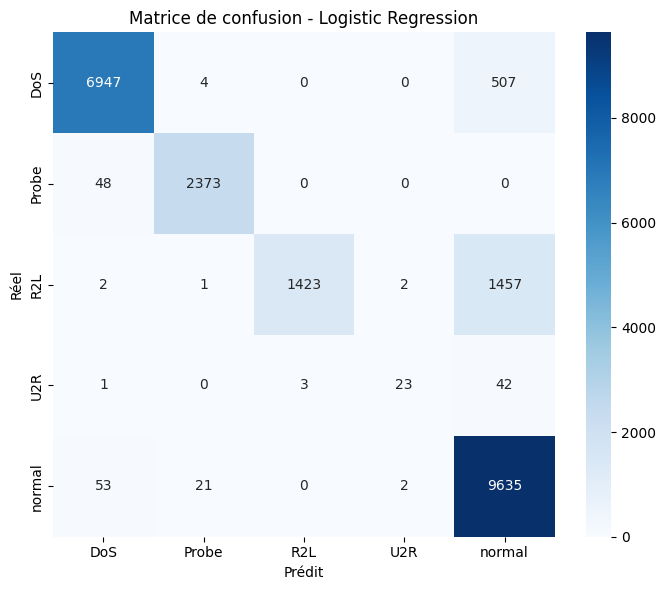


 TPR (Recall) et FPR par classe :
  DoS                  → TPR = 0.93 | FPR = 0.01
  Probe                → TPR = 0.98 | FPR = 0.00
  R2L                  → TPR = 0.49 | FPR = 0.00
  U2R                  → TPR = 0.33 | FPR = 0.00
  normal               → TPR = 0.99 | FPR = 0.16


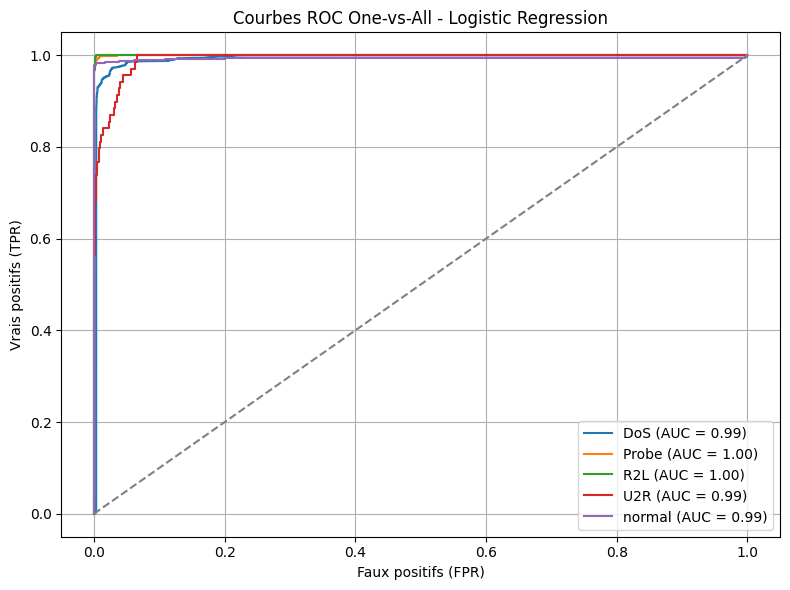

In [ ]:
eval_model_unv(model=lr_clf, X_test=X_test_comb, y_test=y_test, le=le, model_name="Logistic Regression")

## **Comparaison de model**

In [ ]:
eval_metrics = {
    "Modèle": [],
    "Seuil": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

class_names = le.classes_

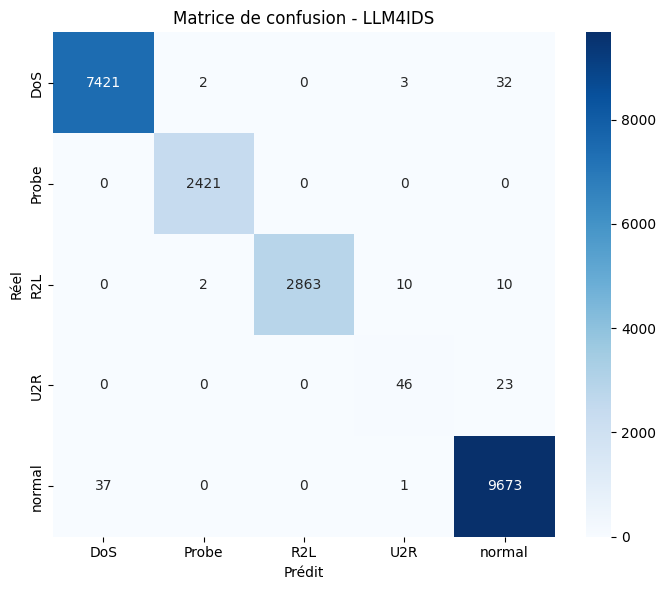

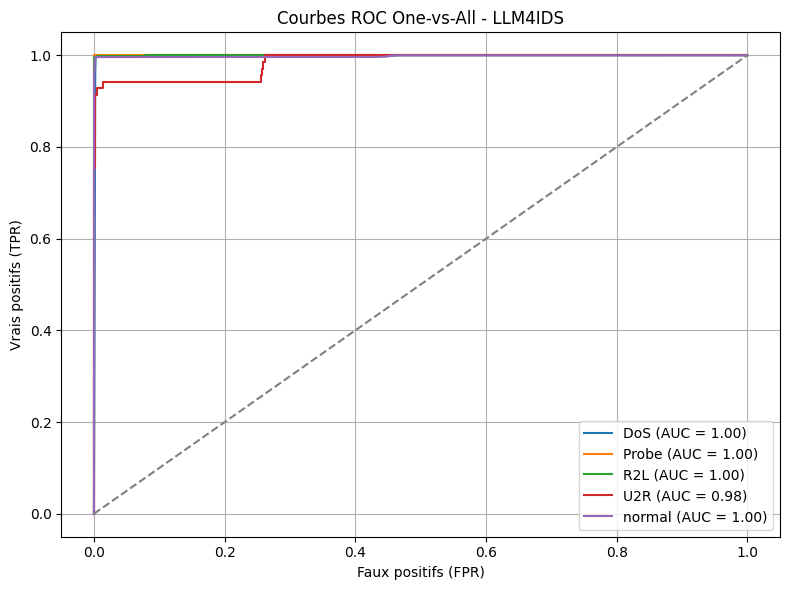

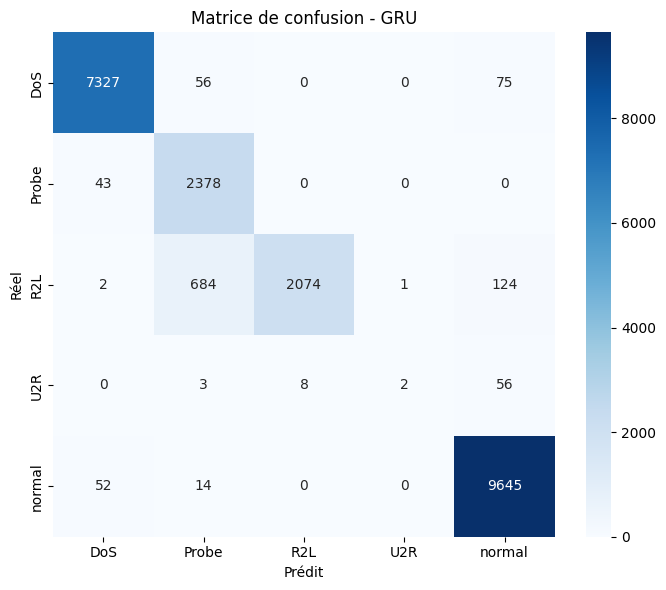

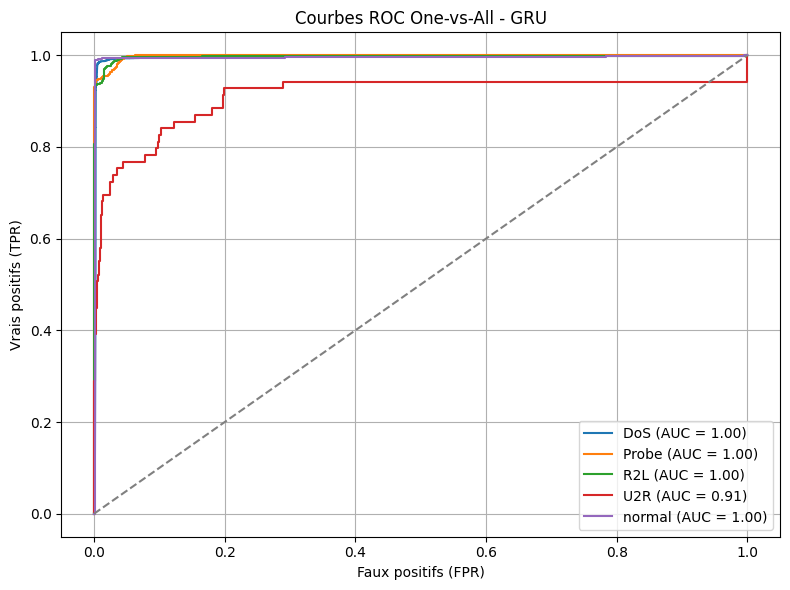

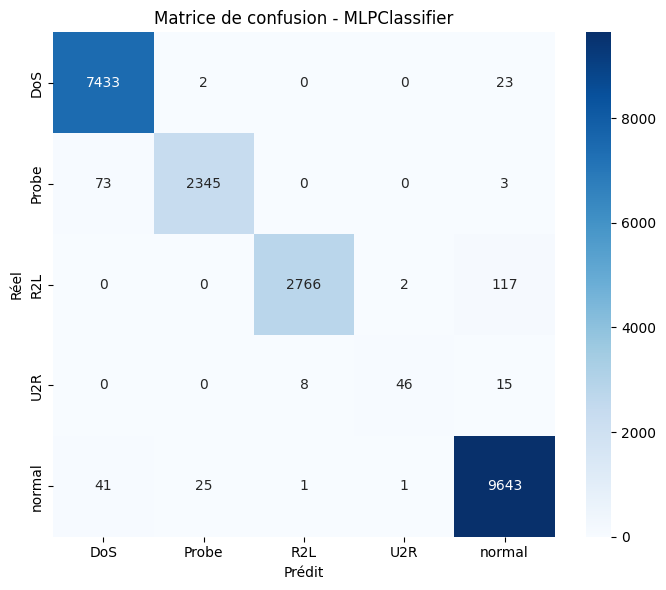

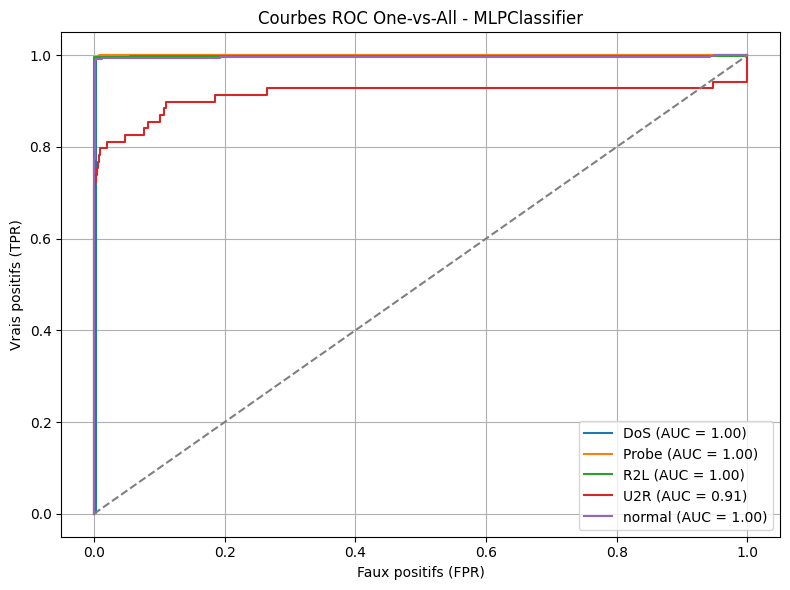

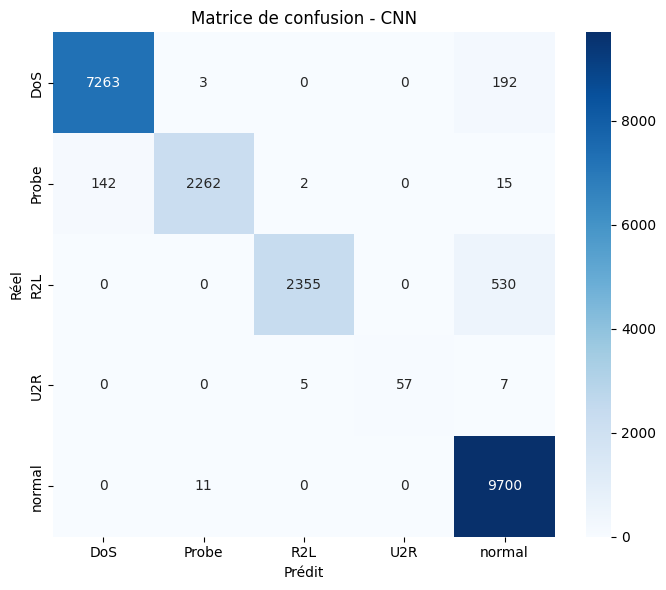

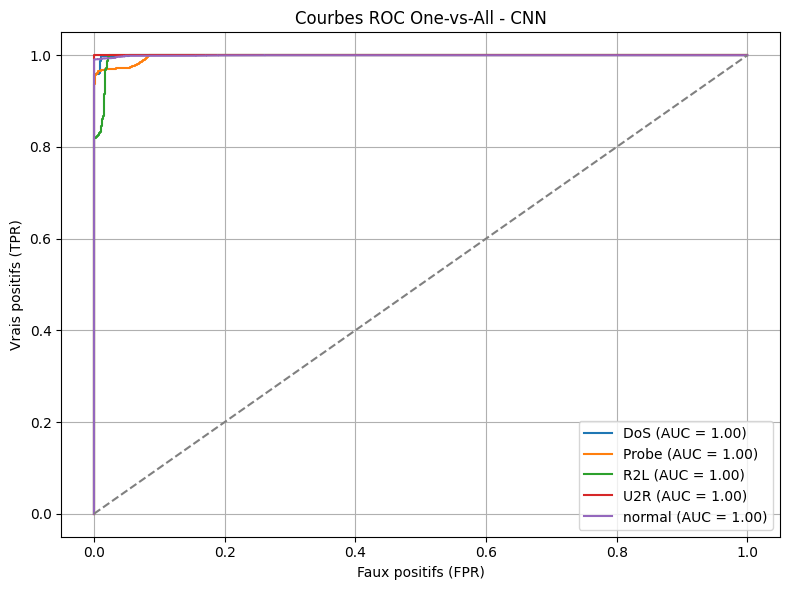

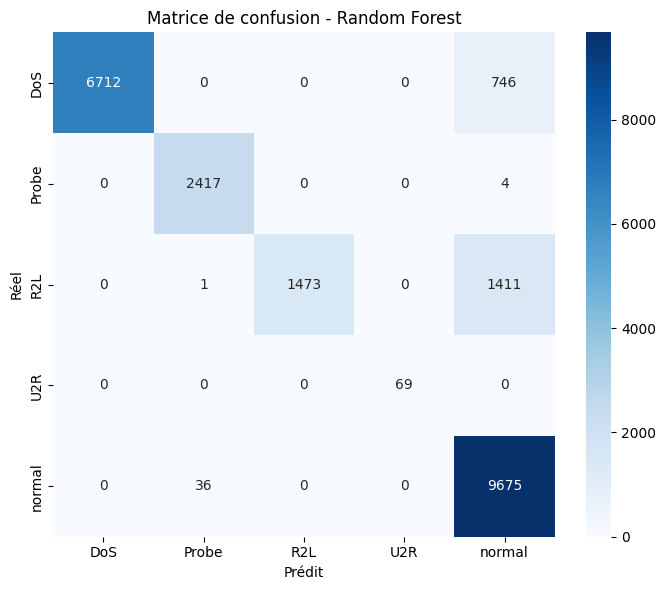

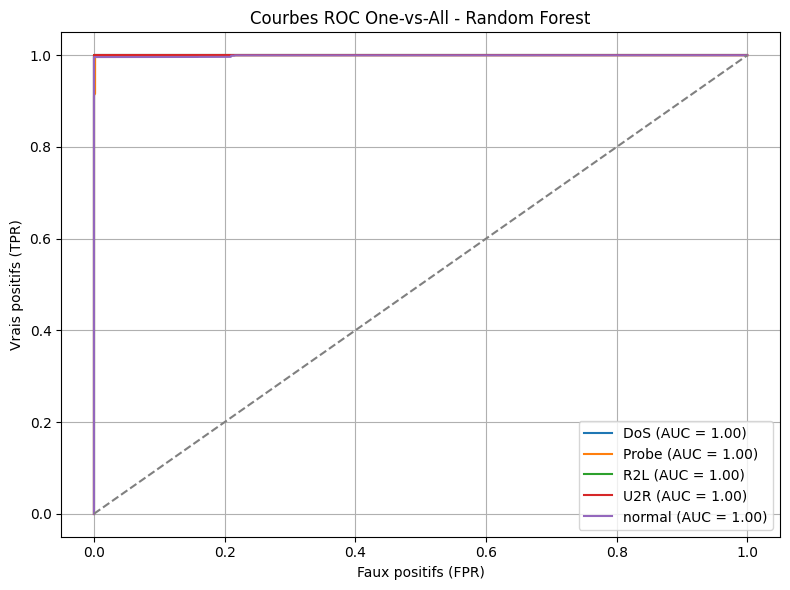

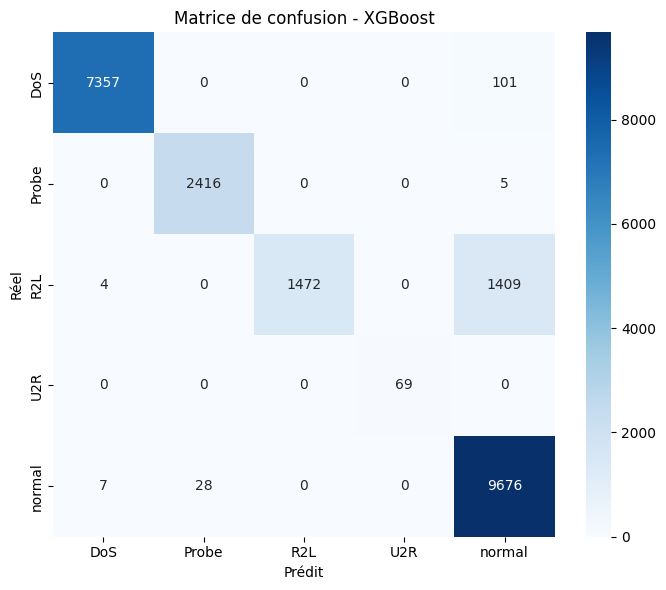

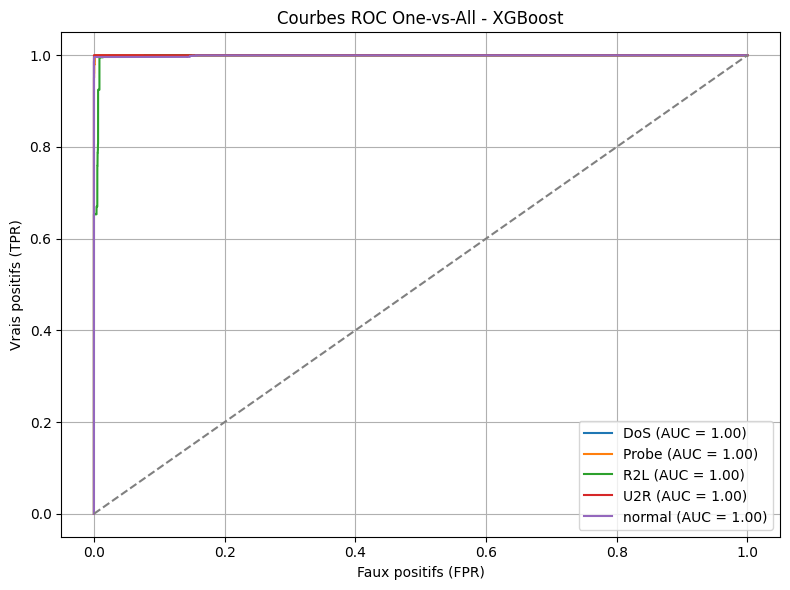

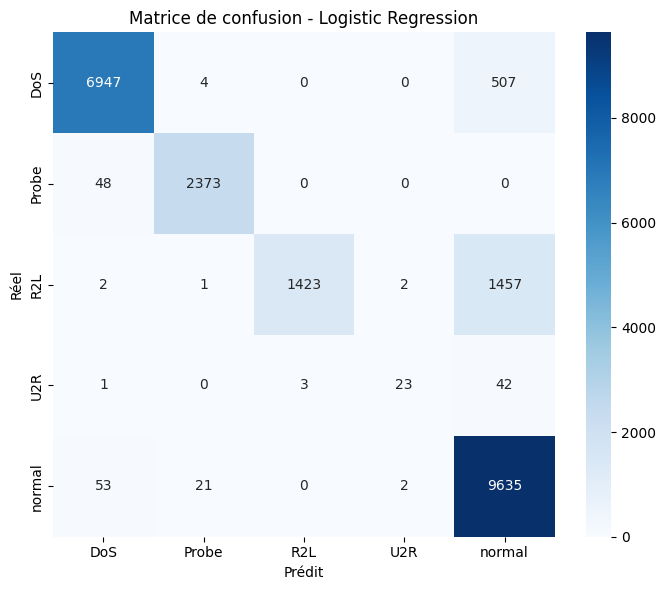

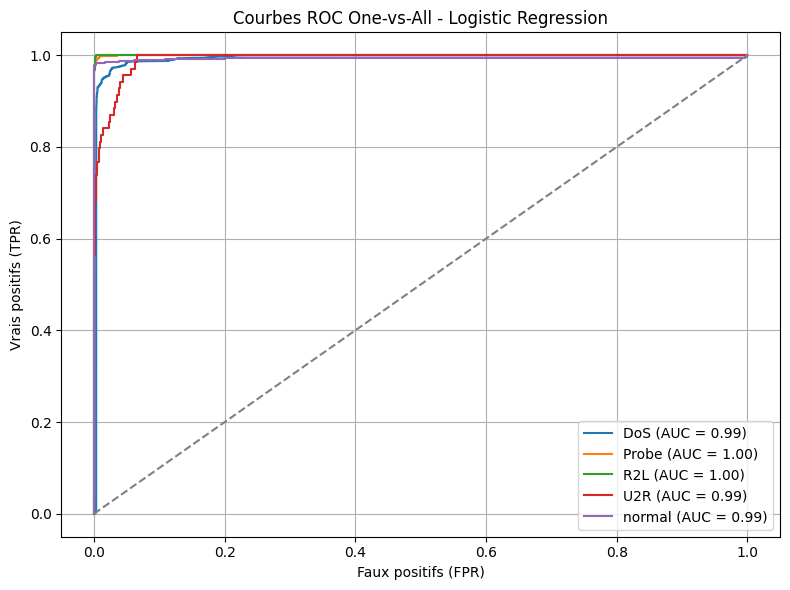

Modèle  Accuracy  Precision  Recall  F1-score
0              LLM4IDS      0.99       0.99    0.99      0.99
1                  GRU      0.95       0.96    0.95      0.95
2        MLPClassifier      0.99       0.99    0.99      0.99
3                  CNN      0.96       0.96    0.96      0.96
4        Random Forest      0.90       0.92    0.90      0.90
5              XGBoost      0.93       0.94    0.93      0.92
6  Logistic Regression      0.90       0.92    0.90      0.90

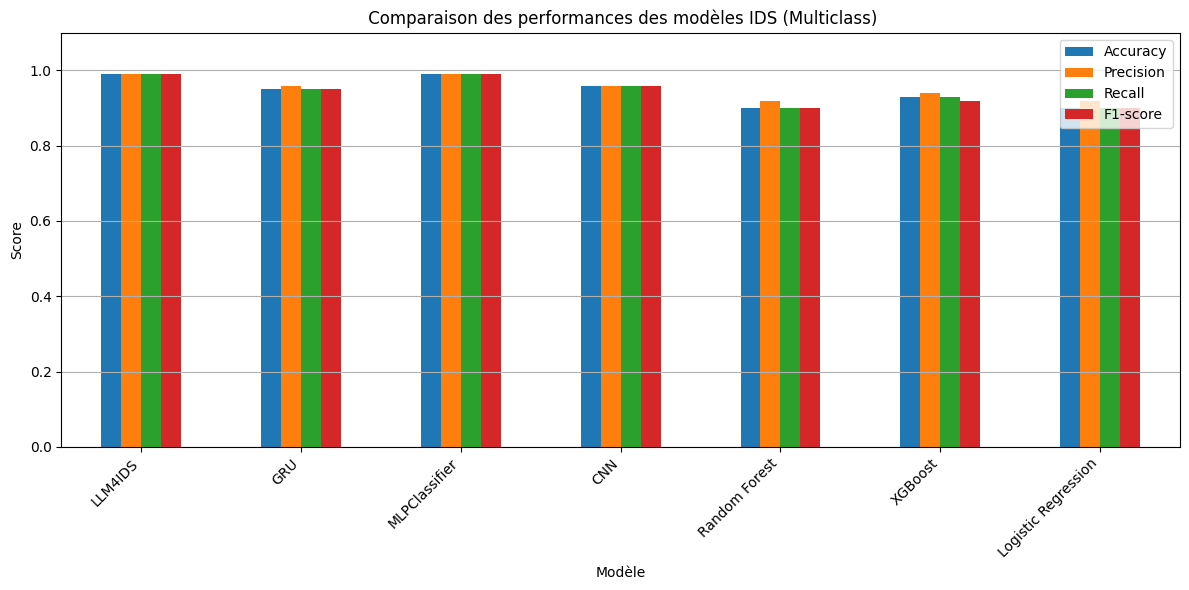

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
from tensorflow.keras.models import load_model
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
from sklearn.preprocessing import label_binarize
import re
import io
import sys

# Ensure models are loaded and le is available (from previous cells)
# llm4ids_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/llm4ids_multiclass_nslkdd.keras")
llm4ids_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/llm4ids_multiclass_nslkdd2.h5")
gru = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/gru_multiclass.keras")
mlp_model = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/mlp_sklearn_llm4ids.pkl")
#cnn_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/cnn_multiclass.keras")
cnn_model = load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/cnn_multiclass.keras")
#rf_loaded = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl")
rf_loaded = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl")
xgb_model = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/xgb_llm4ids_model.pkl")
lr_clf = joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/logistic_regression_llm4ids.pkl")
# le = joblib.load(os.path.join("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models", "label_encoder.pkl"))
#Loard rf

eval_metrics = {
    "Modèle": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

# List of models to evaluate
models_to_evaluate = [
    {"name": "LLM4IDS", "model": llm4ids_model, "X_test": X_test_tf, "y_test": y_test_enc, "keras": True},
    {"name": "GRU", "model": gru, "X_test": X_test_r, "y_test": y_test_enc, "keras": True},
    {"name": "MLPClassifier", "model": mlp_model, "X_test": X_test_comb, "y_test": y_test, "keras": False},
    {"name": "CNN", "model": cnn_model, "X_test": X_test_cnn, "y_test": y_test_enc, "keras": True},
    {"name": "Random Forest", "model": rf_loaded, "X_test": X_test_comb, "y_test": y_test, "keras": False},
    {"name": "XGBoost", "model": xgb_model, "X_test": X_test_comb, "y_test": y_test, "keras": False},
    {"name": "Logistic Regression", "model": lr_clf, "X_test": X_test_comb, "y_test": y_test, "keras": False}
]

# Use eval_model_unv to get metrics and then collect them
for model_info in models_to_evaluate:
    name = model_info["name"]
    model = model_info["model"]
    X_test = model_info["X_test"]
    y_test_true = model_info["y_test"]
    is_keras = model_info["keras"]

    # Capture the classification report output
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()

    # Call the evaluation function (it prints the report)
    eval_model_unv(model=model, X_test=X_test, y_test=y_test_true, le=le, model_name=name)

    sys.stdout = old_stdout
    report = captured_output.getvalue()

    # Extract accuracy, precision, recall, and f1-score from the weighted avg line of the report
    weighted_avg_line = [line for line in report.split('\n') if 'weighted avg' in line]

    if weighted_avg_line:
        metrics = weighted_avg_line[0].split()
        # Assuming the format is 'weighted avg  precision  recall  f1-score  support'
        # We need to find the correct indices for precision, recall, and f1-score
        # The accuracy is on a separate line.

        # Extract accuracy from the accuracy line
        accuracy_line = [line for line in report.split('\n') if 'accuracy' in line]
        accuracy = float(accuracy_line[0].split()[-2]) if accuracy_line else None


        # Extract precision, recall, f1 from the weighted avg line
        # Need to find the index of 'weighted avg' and then the metrics that follow
        try:
            weighted_avg_index = metrics.index('avg') # Look for 'avg' which is part of 'weighted avg'
            prec = float(metrics[weighted_avg_index + 1]) if weighted_avg_index + 1 < len(metrics) else None
            rec = float(metrics[weighted_avg_index + 2]) if weighted_avg_index + 2 < len(metrics) else None
            f1 = float(metrics[weighted_avg_index + 3]) if weighted_avg_index + 3 < len(metrics) else None
        except (ValueError, IndexError):
            prec, rec, f1 = None, None, None


        # Store the collected metrics
        eval_metrics["Modèle"].append(name)
        eval_metrics["Accuracy"].append(accuracy)
        eval_metrics["Precision"].append(prec)
        eval_metrics["Recall"].append(rec)
        eval_metrics["F1-score"].append(f1)
    else:
         # Handle cases where the report format might be unexpected
        print(f"Could not extract weighted average metrics for {name}")
        eval_metrics["Modèle"].append(name)
        eval_metrics["Accuracy"].append(None)
        eval_metrics["Precision"].append(None)
        eval_metrics["Recall"].append(None)
        eval_metrics["F1-score"].append(None)


# Display the comparison table
metrics_df = pd.DataFrame(eval_metrics)
display(metrics_df)

# Plot the comparison
metrics_df.set_index("Modèle")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", figsize=(12, 6))
plt.title(" Comparaison des performances des modèles IDS (Multiclass)")
plt.ylabel("Score")
plt.ylim(0, 1.1) # Adjusted y-limit for clarity
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()

Model  Accuracy  Precision  Recall  F1-score
0              LLM4IDS      0.99       0.99    0.99      0.99
1                  GRU      0.95       0.96    0.95      0.95
2        MLPClassifier      0.99       0.99    0.99      0.99
3                  CNN      0.96       0.96    0.96      0.96
4        Random Forest      0.90       0.92    0.90      0.90
5              XGBoost      0.93       0.94    0.93      0.92
6  Logistic Regression      0.90       0.92    0.90      0.90

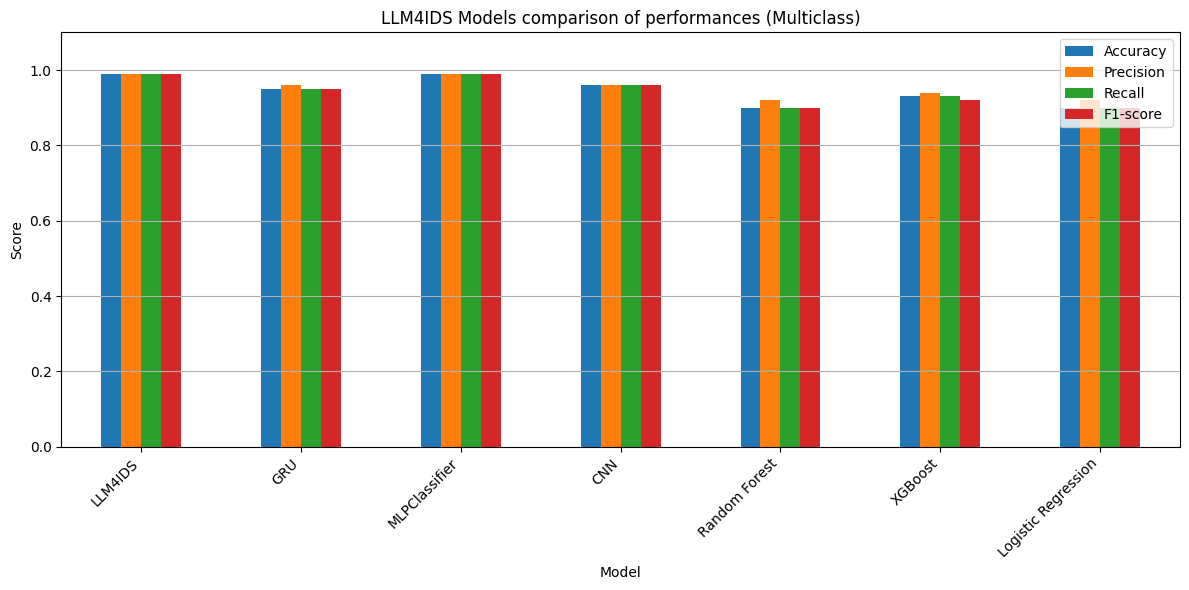

In [ ]:
from sklearn.metrics import classification_report
import numpy as np
import io
import sys
import pandas as pd
import re

eval_metrics = {
    "Model": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}

for model_info in models_to_evaluate:
    name = model_info["name"]
    model = model_info["model"]
    X_test = model_info["X_test"]
    y_test_true = model_info["y_test"]
    is_keras = model_info["keras"]

    # Prédictions
    if is_keras:
        y_pred = model.predict(X_test)
        y_pred_labels = np.argmax(y_pred, axis=1)
    else:
        y_pred_labels = model.predict(X_test)

    # Harmonisation des formats
    y_test_true = np.array(y_test_true)
    y_pred_labels = np.array(y_pred_labels)

    # Si y_test est one-hot
    if len(y_test_true.shape) > 1 and y_test_true.shape[1] > 1:
        y_test_true = np.argmax(y_test_true, axis=1)

    # Si y_test contient des chaînes
    if isinstance(y_test_true[0], str):
        y_test_true = le.transform(y_test_true)

    if isinstance(y_pred_labels[0], str):
        y_pred_labels = le.transform(y_pred_labels)

    # Capture du rapport
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()
    print(classification_report(y_test_true, y_pred_labels))
    sys.stdout = old_stdout
    report = captured_output.getvalue()

    # Extraction des lignes
    weighted_avg_line = [line for line in report.split('\n') if 'weighted avg' in line]
    accuracy_line = [line for line in report.split('\n') if 'accuracy' in line]

    try:
        accuracy = float(accuracy_line[0].split()[-2]) if accuracy_line else None
        if weighted_avg_line:
            metrics = re.split(r'\s+', weighted_avg_line[0].strip())
            precision = float(metrics[2])
            recall = float(metrics[3])
            f1 = float(metrics[4])
        else:
            precision = recall = f1 = None

        eval_metrics["Model"].append(name)
        eval_metrics["Accuracy"].append(accuracy)
        eval_metrics["Precision"].append(precision)
        eval_metrics["Recall"].append(recall)
        eval_metrics["F1-score"].append(f1)

    except Exception as e:
        print(f"Erreur pour {name} : {e}")
        eval_metrics["Model"].append(name)
        eval_metrics["Accuracy"].append(None)
        eval_metrics["Precision"].append(None)
        eval_metrics["Recall"].append(None)
        eval_metrics["F1-score"].append(None)

# Résultats
metrics_df = pd.DataFrame(eval_metrics)
display(metrics_df)

# Graphe
metrics_df.set_index("Model")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", figsize=(12, 6))
plt.title("LLM4IDS Models comparison of performances (Multiclass)")
plt.ylabel("Score")
plt.ylim(0, 1.1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


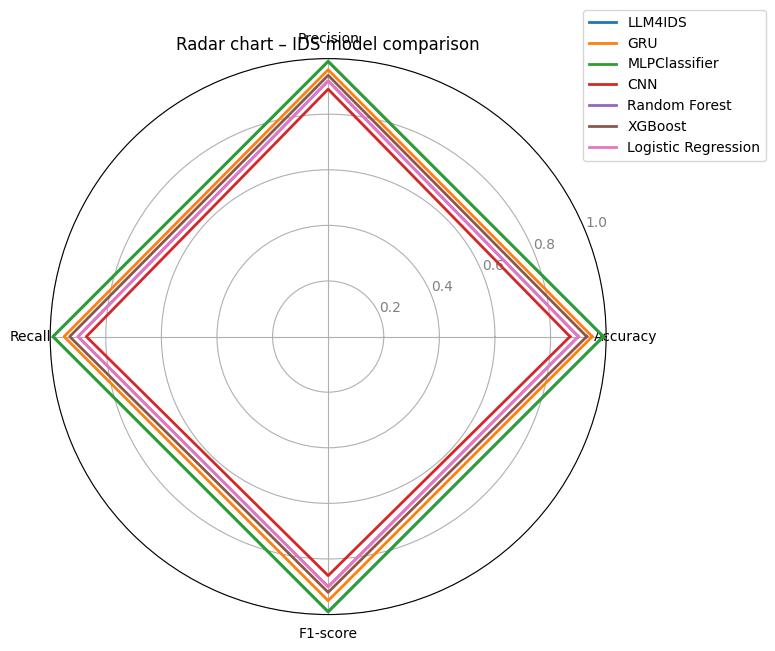

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

labels = ["Accuracy", "Precision", "Recall", "F1-score"]
num_vars = len(labels)

angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]  # boucle fermée

plt.figure(figsize=(8, 8))
for i, row in metrics_df.iterrows():
    values = row[labels].tolist()
    values += values[:1]
    plt.polar(angles, values, label=row["Modèle"], linewidth=2)

plt.xticks(angles[:-1], labels)
plt.yticks([0.2, 0.4, 0.6, 0.8, 1.0], color="gray")
plt.title("Radar chart – IDS model comparison")
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


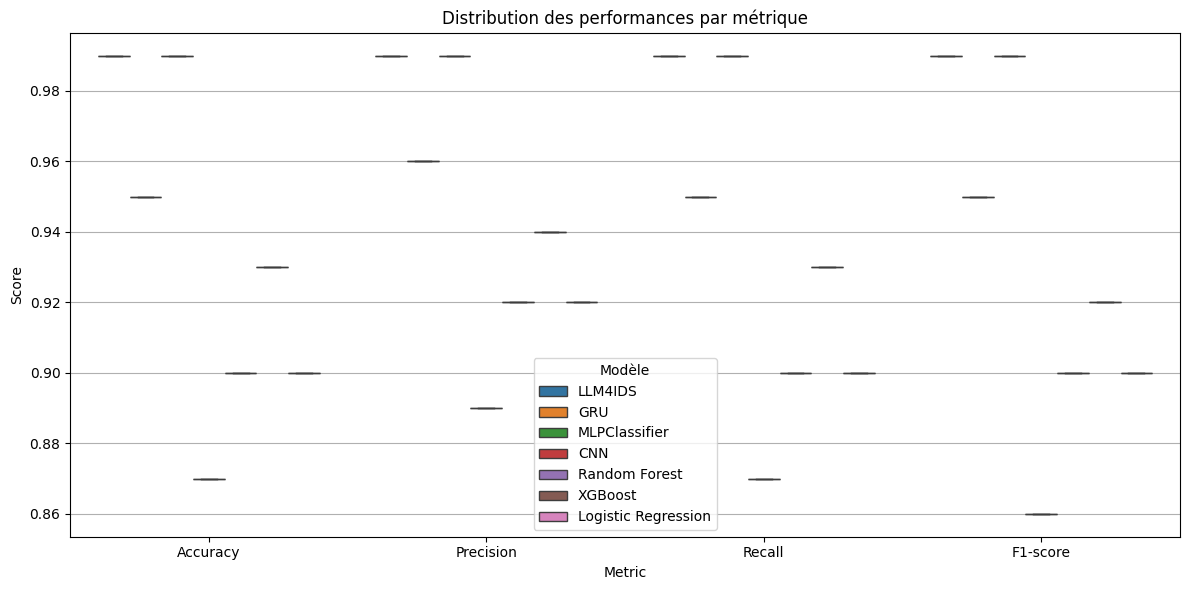

In [ ]:
# Exemple avec données multiples
long_df = pd.melt(metrics_df, id_vars="Modèle", var_name="Metric", value_name="Score")

plt.figure(figsize=(12, 6))
sns.boxplot(x="Metric", y="Score", hue="Modèle", data=long_df)
plt.title("Distribution des performances par métrique")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


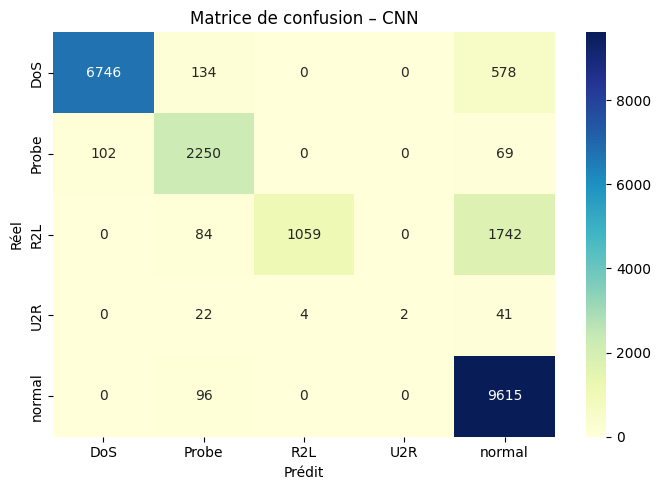

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Exemple : confusion matrix du modèle CNN
y_true = np.argmax(y_test_enc, axis=1)
y_pred = np.argmax(cnn_model.predict(X_test_cnn), axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = le.classes_ if hasattr(le, 'classes_') else ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion – CNN")
plt.tight_layout()
plt.show()


705/705 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step


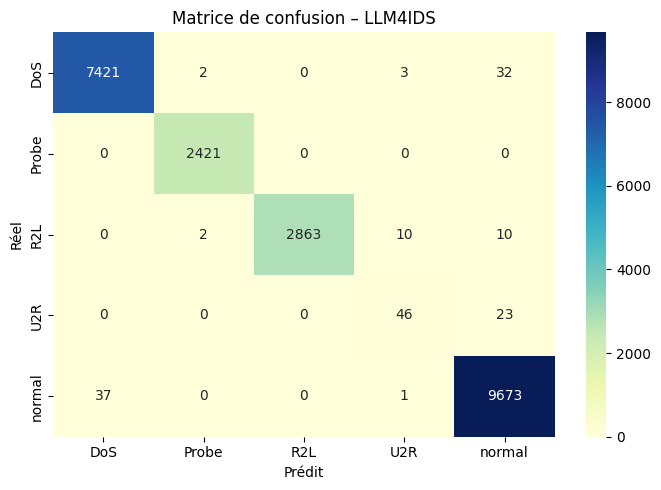

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Exemple : confusion matrix du modèle CNN
y_true = np.argmax(y_test_enc, axis=1)
y_pred = np.argmax(llm4ids_model.predict(X_test_tf), axis=1)

cm = confusion_matrix(y_true, y_pred)
labels = le.classes_ if hasattr(le, 'classes_') else ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=labels, yticklabels=labels, cmap="YlGnBu")
plt.xlabel("Prédit")
plt.ylabel("Réel")
plt.title("Matrice de confusion – LLM4IDS")
plt.tight_layout()
plt.show()


### Evaluation2

In [ ]:
def collect_scores(model, X_test, y_test, le, model_name, keras=False, model_path=None):
    # === 1. Prédiction
    if keras:
        y_score = model.predict(X_test, verbose=0)
        y_pred = np.argmax(y_score, axis=1)
        y_true = np.argmax(y_test, axis=1) if len(y_test.shape) > 1 else y_test
    else:
        y_pred = model.predict(X_test)
        y_true = y_test

    # === 2. Harmonisation des types
    if isinstance(y_true[0], str) and not isinstance(y_pred[0], str):
        y_pred = le.inverse_transform(y_pred)
    elif not isinstance(y_true[0], str) and isinstance(y_pred[0], str):
        y_true = le.inverse_transform(y_true)

    # === 3. Scores
    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')

    # === 4. Inference time
    inf_time = measure_inference_time(model, X_test, keras=keras)

    # === 5. Taille du modèle
    size = get_model_size(model_path) if model_path else None

    return {
        "Modèle": model_name,
        "Accuracy": round(acc * 100, 2),
        "F1-score": round(f1 * 100, 2),
        "Temps inf. (ms/ex)": inf_time,
        "Taille (MB)": size
    }


In [ ]:
import time
import numpy as np

def measure_inference_time(model, X, keras=False, n_repeats=3):
    times = []
    for _ in range(n_repeats):
        start = time.time()
        if keras:
            _ = model.predict(X, verbose=0)
        else:
            _ = model.predict(X)
        end = time.time()
        times.append(end - start)
    avg_total_time = np.mean(times)
    return round(avg_total_time / X.shape[0] * 1000, 3)  # en millisecondes / échantillon


In [ ]:
import os

def get_model_size(filepath):
    if filepath and os.path.exists(filepath):
        return round(os.path.getsize(filepath) / (1024 * 1024), 2)  # MB
    else:
        return None


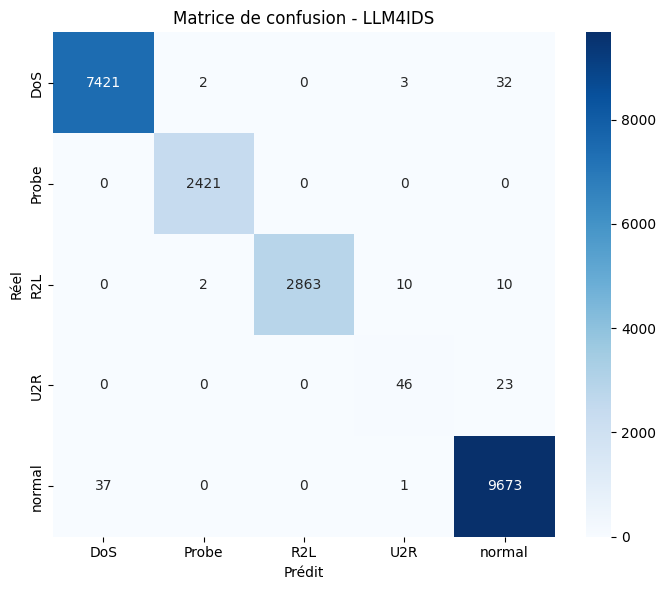

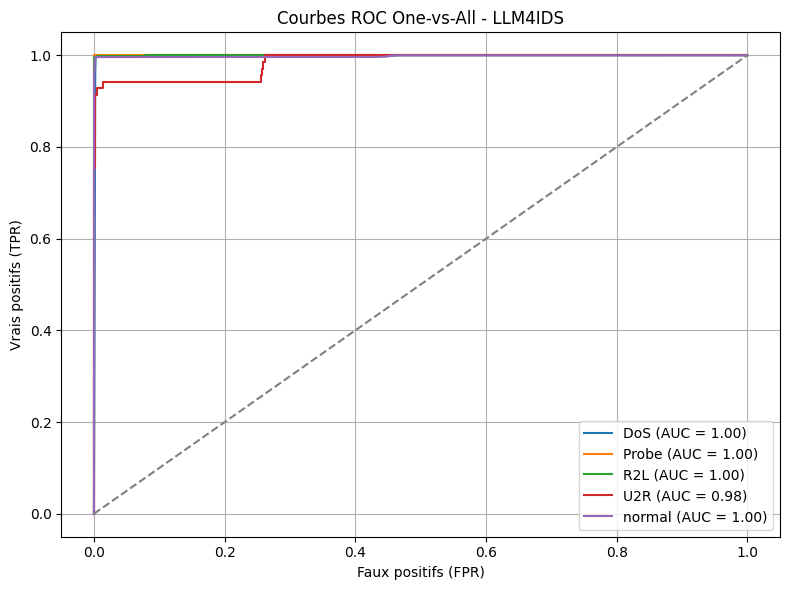

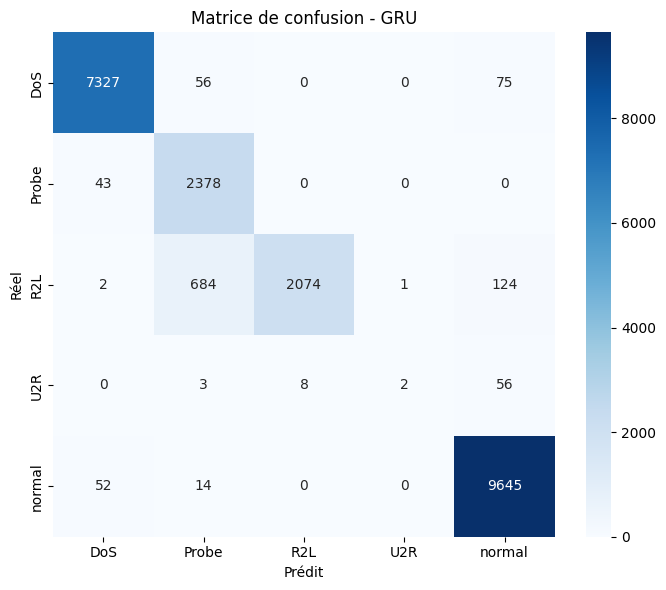

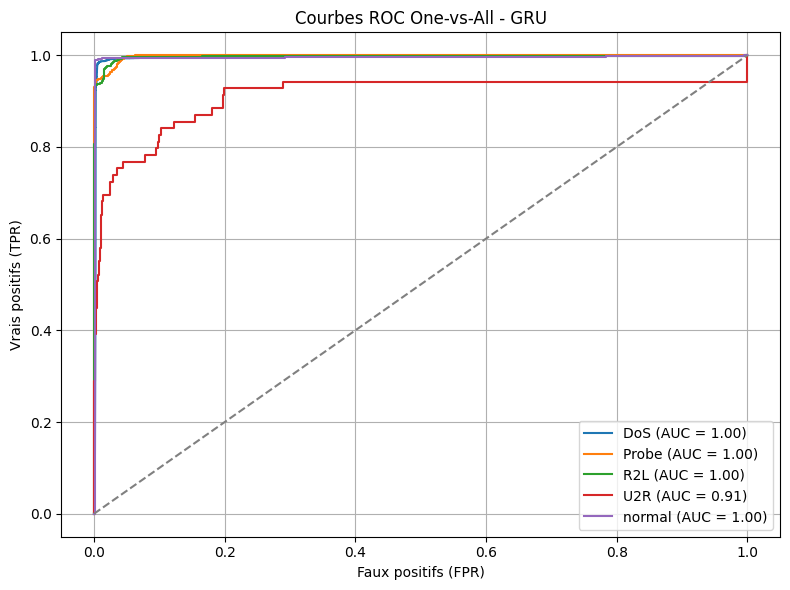

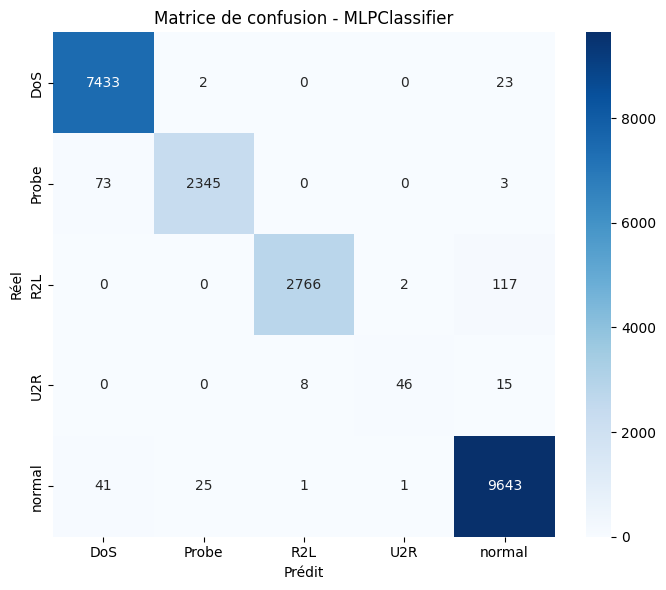

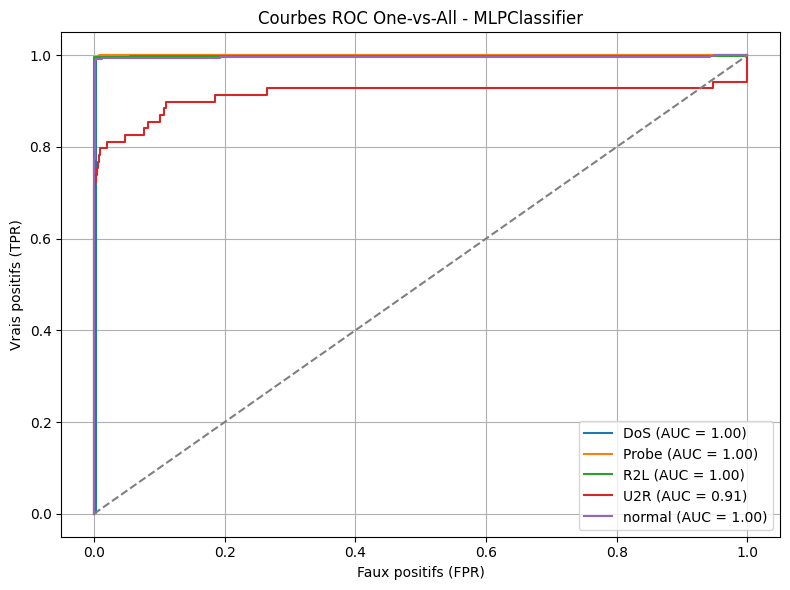

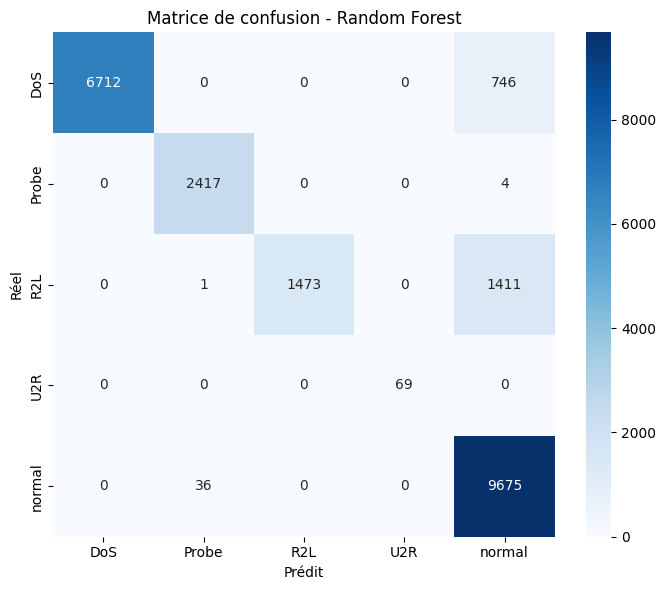

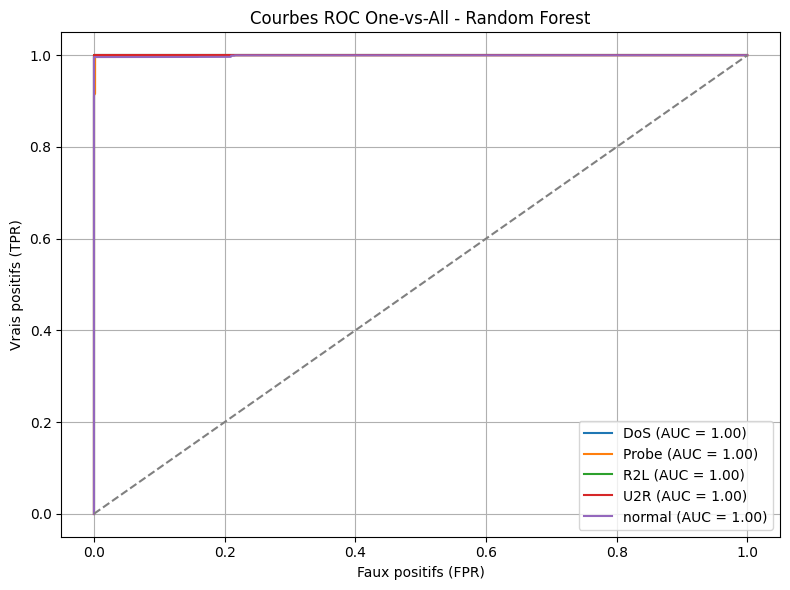

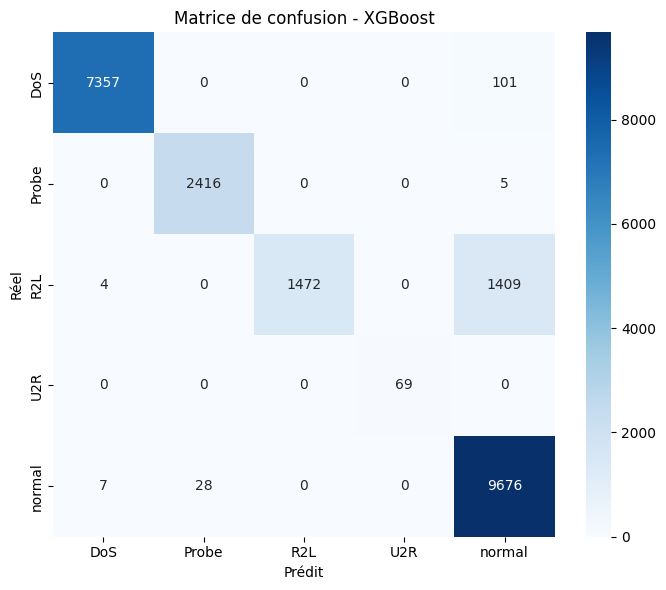

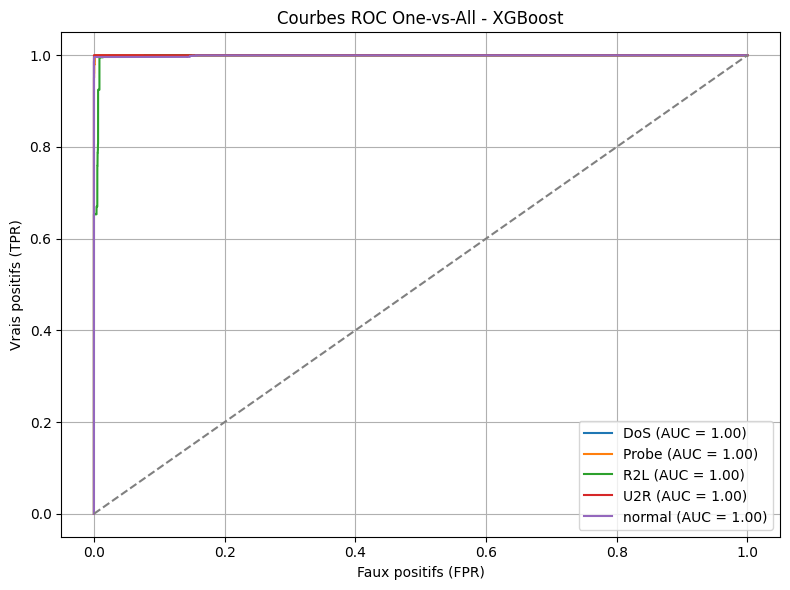

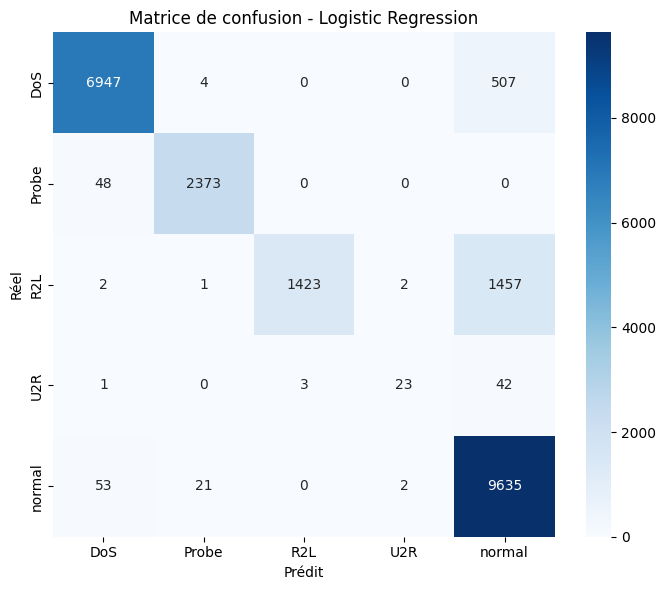

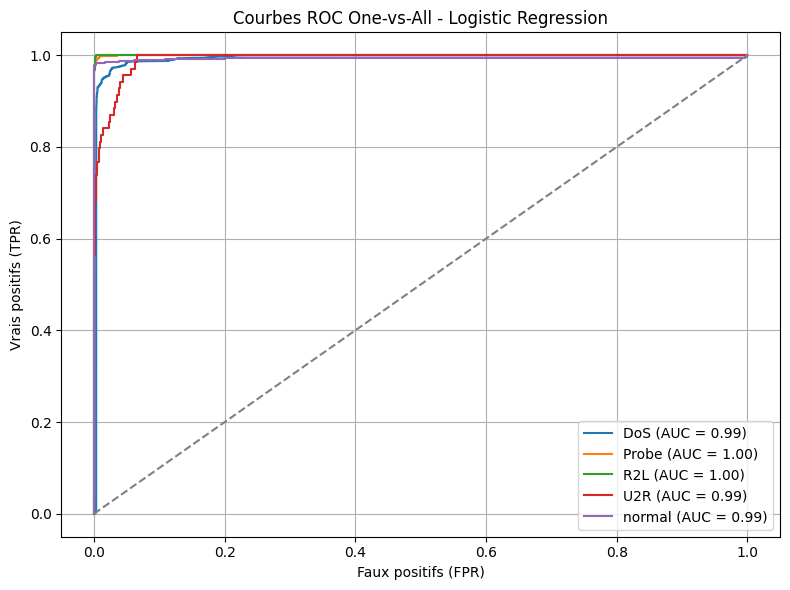

In [ ]:
from sklearn.metrics import classification_report
import io
import sys

scores = []
# Exemple : X_test est de forme (n_samples, n_features)

# List of models to evaluate
models_to_evaluate = [
    {"name": "LLM4IDS", "model": llm4ids_model, "X_test": X_test_tf, "y_test": y_test_enc, "keras": True, "model_path": "LLM4-IDS/nsl-kdd/models/llm4ids_multiclass_nslkdd.keras"},
    {"name": "GRU", "model": gru, "X_test": X_test, "y_test": y_test_enc, "keras": True, "model_path": "LLM4-IDS/nsl-kdd/models/gru_multiclass.keras"},
    {"name": "MLPClassifier", "model": mlp_model, "X_test": X_test_comb, "y_test": y_test, "keras": False, "model_path": "LLM4-IDS/nsl-kdd/models/mlp_sklearn_llm4ids.pkl"},
    {"name": "Random Forest", "model": rf_loaded, "X_test": X_test_comb, "y_test": y_test, "keras": False, "model_path": "LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl"},
    {"name": "XGBoost", "model": xgb_model, "X_test": X_test_comb, "y_test": y_test, "keras": False, "model_path": "LLM4-IDS/nsl-kdd/models/xgb_llm4ids_model.pkl"},
    {"name": "Logistic Regression", "model": lr_clf, "X_test": X_test_comb, "y_test": y_test, "keras": False, "model_path": "LLM4-IDS/nsl-kdd/models/logistic_regression_llm4ids.pkl"}
]

# Use eval_model_unv to get metrics and then collect them
for model_info in models_to_evaluate:
    name = model_info["name"]
    model = model_info["model"]
    X_test = model_info["X_test"]
    y_test_true = model_info["y_test"]
    is_keras = model_info["keras"]
    model_path = model_info["model_path"]

    # Capture the classification report output
    old_stdout = sys.stdout
    sys.stdout = captured_output = io.StringIO()

    eval_model_unv(model=model, X_test=X_test, y_test=y_test_true, le=le, model_name=name)

    sys.stdout = old_stdout
    report = captured_output.getvalue()

    # Extract accuracy and weighted avg f1-score from the report
    accuracy_line = [line for line in report.split('\n') if 'accuracy' in line]
    f1_weighted_line = [line for line in report.split('\n') if 'weighted avg' in line]

    accuracy = float(accuracy_line[0].split()[-2]) if accuracy_line else None
    f1_weighted = float(f1_weighted_line[0].split()[-2]) if f1_weighted_line else None

    # Get inference time and model size
    inf_time = measure_inference_time(model, X_test, keras=is_keras)
    size = get_model_size(model_path)

    scores.append({
        "Modèle": name,
        "Accuracy": round(accuracy * 100, 2) if accuracy is not None else None,
        "F1-score": round(f1_weighted * 100, 2) if f1_weighted is not None else None,
        "Temps inf. (ms/ex)": inf_time,
        "Taille (MB)": size
    })

/tmp/ipython-input-39-2717727522.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="Accuracy", data=df_scores, palette="viridis")


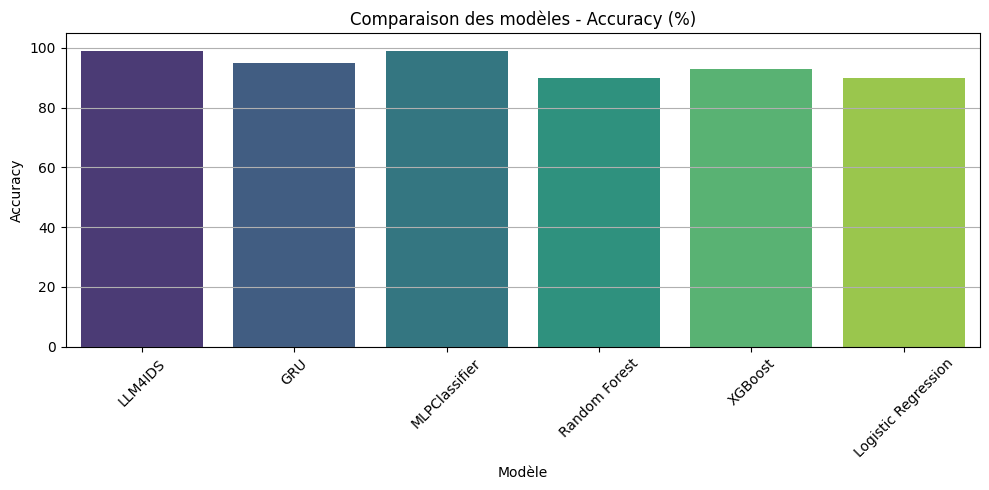

/tmp/ipython-input-39-2717727522.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="F1-score", data=df_scores, palette="magma")


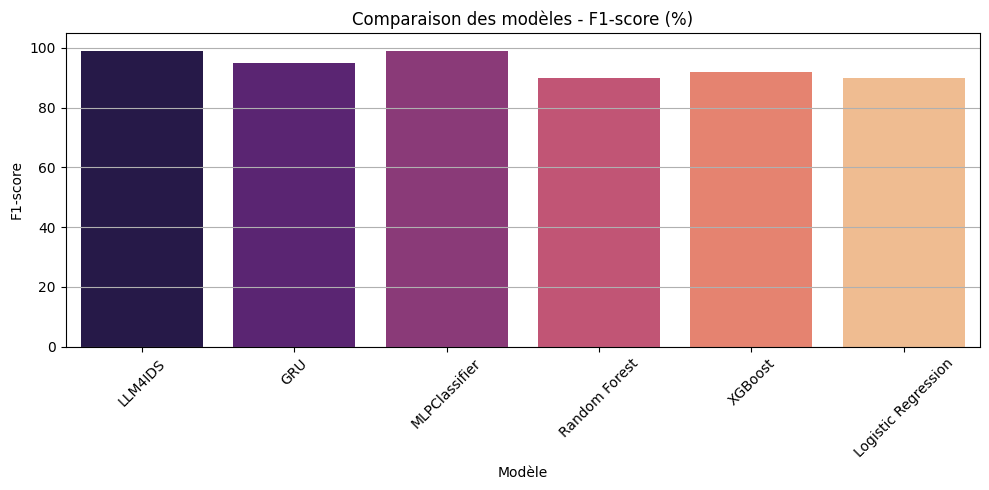

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

df_scores = pd.DataFrame(scores)

# Accuracy plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="Accuracy", data=df_scores, palette="viridis")
plt.title("Comparaison des modèles - Accuracy (%)")
plt.ylim(0, 105)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# F1-score plot
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="F1-score", data=df_scores, palette="magma")
plt.title("Comparaison des modèles - F1-score (%)")
plt.ylim(0, 105)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_best_model_per_class_roc(models_info, X_test_dict, y_test, le):
    """
    Affiche une courbe ROC par classe, avec le meilleur modèle pour chaque.

    Parameters:
    - models_info : list of dicts with keys:
        - "name": nom du modèle
        - "model": l'objet modèle
        - "keras": True/False
        - "X_test": données d'entrée
    - y_test : ground truth (one-hot or int)
    - le : LabelEncoder utilisé
    """

    # 1. Préparation
    if len(y_test.shape) > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))
    best_aucs = [-1] * len(le.classes_)
    best_curves = [None] * len(le.classes_)
    best_models = [""] * len(le.classes_)

    # 2. Pour chaque modèle, calculer les courbes ROC par classe
    for info in models_info:
        name = info["name"]
        model = info["model"]
        keras = info["keras"]
        X = info["X_test"]

        if keras:
            y_score = model.predict(X, verbose=0)
        elif hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)
        else:
            continue

        for i, class_name in enumerate(le.classes_):
            if np.sum(y_bin[:, i]) == 0:
                continue
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc = roc_auc_score(y_bin[:, i], y_score[:, i])

            if auc > best_aucs[i]:
                best_aucs[i] = auc
                best_curves[i] = (fpr, tpr)
                best_models[i] = name

    # 3. Tracer les meilleures courbes par classe
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(le.classes_):
        if best_curves[i] is not None:
            fpr, tpr = best_curves[i]
            auc = best_aucs[i]
            plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc:.2f}, {best_models[i]})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("Courbe ROC - Meilleur modèle par classe")
    plt.xlabel("Faux positifs (FPR)")
    plt.ylabel("Vrais positifs (TPR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot_model_comparison(df_scores):
    sns.set(style="whitegrid")
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    fig.suptitle(" Comparaison des Modèles LLM4IDS (NSL-KDD)", fontsize=16, fontweight='bold')

    # 1. Accuracy
    sns.barplot(x="Accuracy", y="Modèle", data=df_scores, ax=axes[0, 0], palette="viridis")
    axes[0, 0].set_title(" Accuracy (%)")
    axes[0, 0].set_xlim(0, 105)

    # 2. F1-score
    sns.barplot(x="F1-score", y="Modèle", data=df_scores, ax=axes[0, 1], palette="magma")
    axes[0, 1].set_title(" F1-score (%)")
    axes[0, 1].set_xlim(0, 105)

    # 3. Temps d’inférence
    sns.barplot(x="Temps inf. (ms/ex)", y="Modèle", data=df_scores, ax=axes[1, 0], palette="crest")
    axes[1, 0].set_title("⏱ Temps d'inférence (ms/exemple)")

    # 4. Taille du modèle
    sns.barplot(x="Taille (MB)", y="Modèle", data=df_scores, ax=axes[1, 1], palette="flare")
    axes[1, 1].set_title(" Taille du modèle (MB)")

    # Mise en forme
    for ax in axes.flat:
        ax.bar_label(ax.containers[0], fmt="%.2f", label_type='edge')
        ax.set_ylabel("")
        ax.grid(axis='x', linestyle='--', alpha=0.5)

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()


/tmp/ipython-input-41-1077342824.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Accuracy", y="Modèle", data=df_scores, ax=axes[0, 0], palette="viridis")
/tmp/ipython-input-41-1077342824.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="F1-score", y="Modèle", data=df_scores, ax=axes[0, 1], palette="magma")
/tmp/ipython-input-41-1077342824.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Temps inf. (ms/ex)", y="Modèle", data=df_scores, ax=axes[1, 0], palette="crest")
/tmp/ipython-input-41-1077342824.py:24: FutureWarning: 

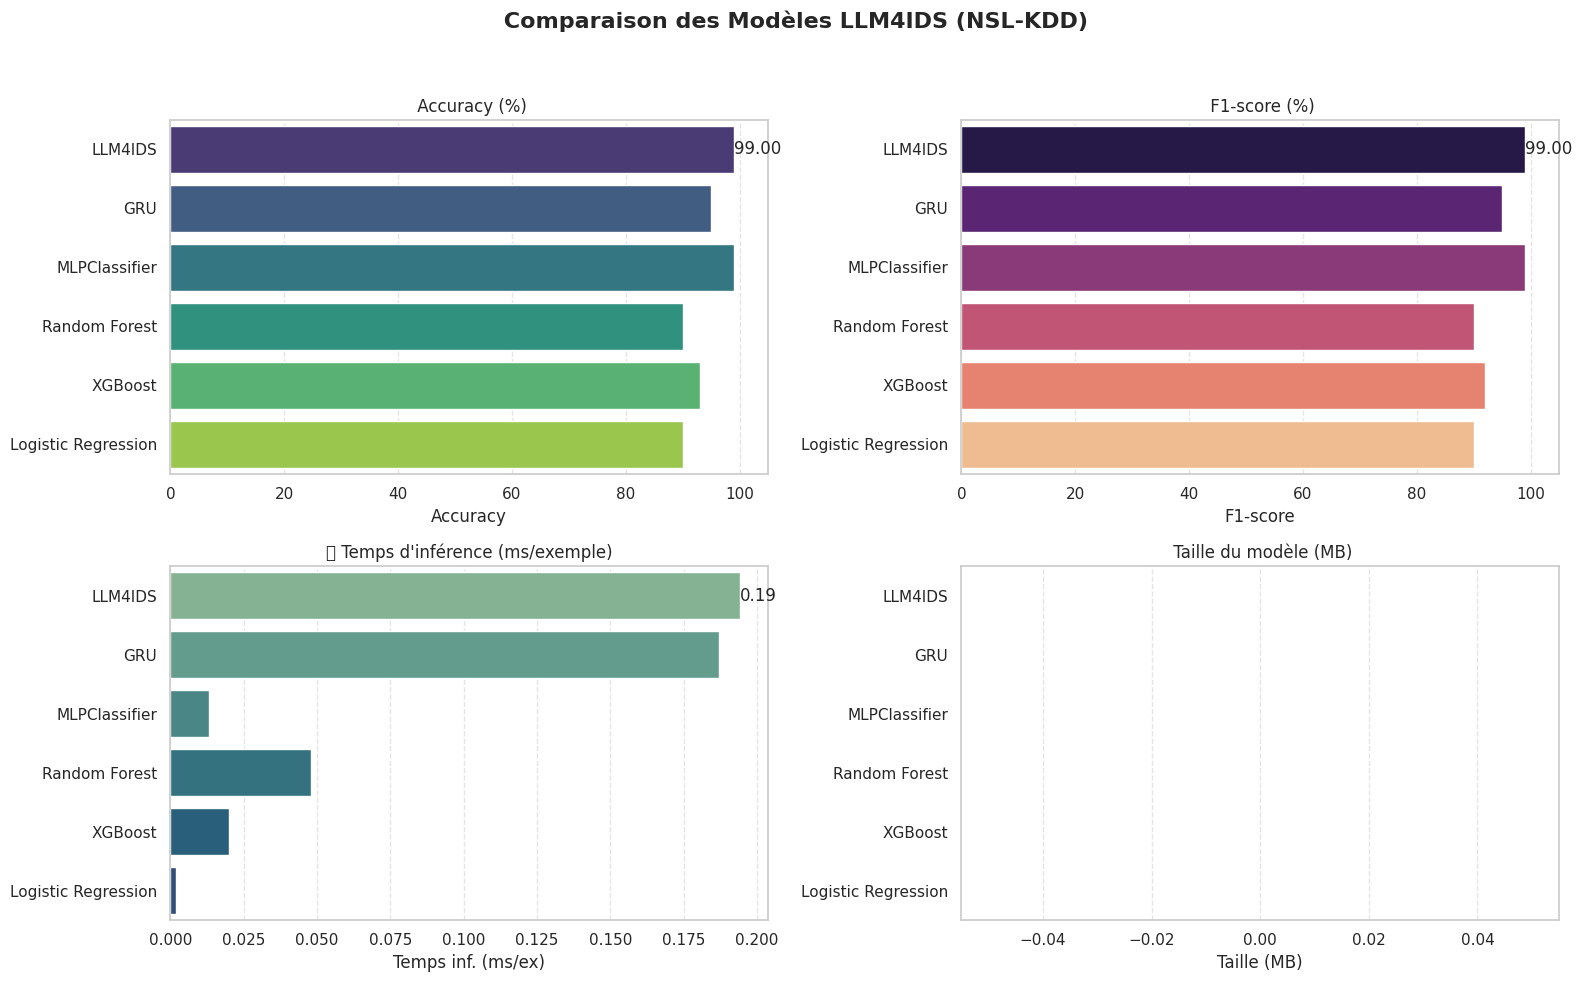

In [ ]:
plot_model_comparison(df_scores)


In [ ]:
import joblib
import tensorflow as tf
import numpy as np

# Dictionnaire de résultats
eval_metrics = {
    "Modèle": [],
    "Accuracy": [],
    "Precision": [],
    "Recall": [],
    "F1-score": []
}


In [ ]:
import pandas as pd

df_results = pd.DataFrame(eval_metrics)
df_results.sort_values("F1-score", ascending=False, inplace=True)
display(df_results)


Modèle  Accuracy  Precision  Recall  F1-score
0              LLM4IDS      0.99       0.99    0.99      0.99
2        MLPClassifier      0.99       0.99    0.99      0.99
1                  GRU      0.95       0.96    0.95      0.95
5              XGBoost      0.93       0.94    0.93      0.92
4        Random Forest      0.90       0.92    0.90      0.90
6  Logistic Regression      0.90       0.92    0.90      0.90
3                  CNN      0.87       0.89    0.87      0.86

Modèle  Accuracy  Precision  Recall  F1-score
0              LLM4IDS      0.99       0.99    0.99      0.99
1                  GRU      0.95       0.96    0.95      0.95
2        MLPClassifier      0.99       0.99    0.99      0.99
3                  CNN      0.87       0.89    0.87      0.86
4        Random Forest      0.90       0.92    0.90      0.90
5              XGBoost      0.93       0.94    0.93      0.92
6  Logistic Regression      0.90       0.92    0.90      0.90

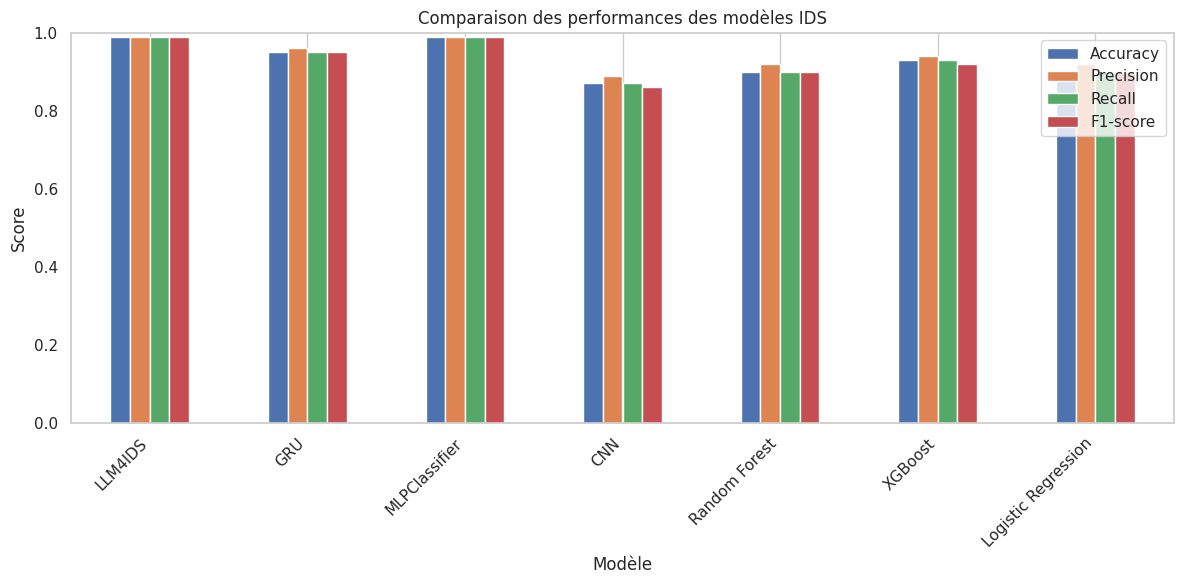

In [ ]:
metrics_df = pd.DataFrame(eval_metrics)
display(metrics_df)

metrics_df.set_index("Modèle")[["Accuracy", "Precision", "Recall", "F1-score"]].plot(kind="bar", figsize=(12, 6))
plt.title("Comparaison des performances des modèles IDS")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


/tmp/ipython-input-45-4173937429.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="Accuracy", data=df_scores, palette="viridis")


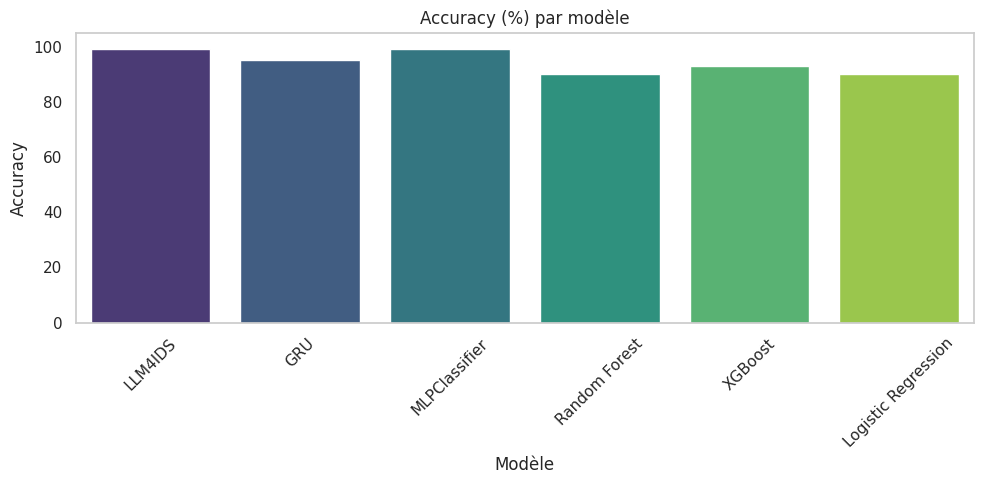

/tmp/ipython-input-45-4173937429.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="F1-score", data=df_scores, palette="magma")


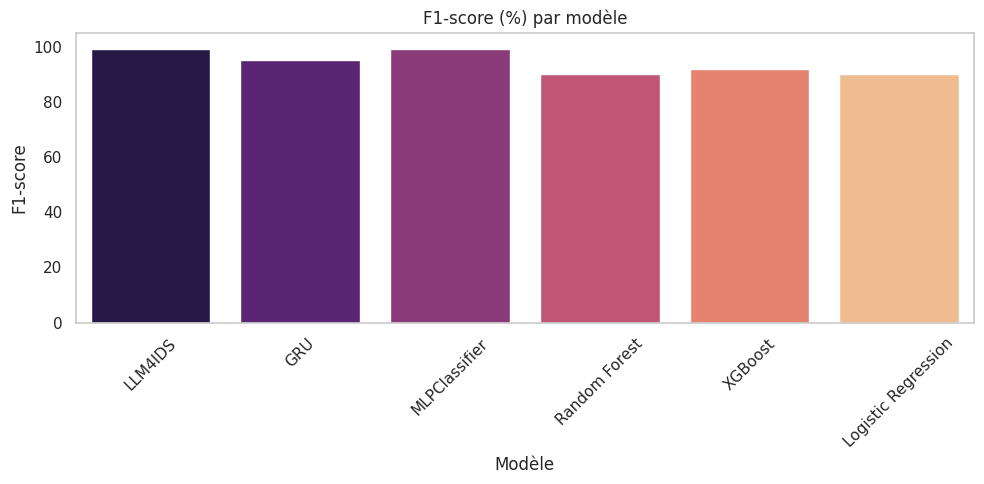

/tmp/ipython-input-45-4173937429.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="Temps inf. (ms/ex)", data=df_scores, palette="crest")


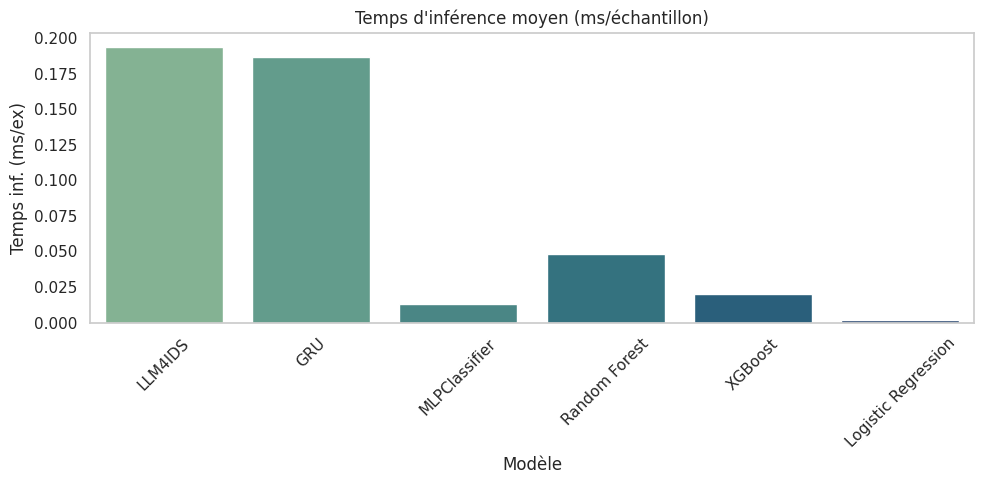

/tmp/ipython-input-45-4173937429.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Modèle", y="Taille (MB)", data=df_scores, palette="flare")


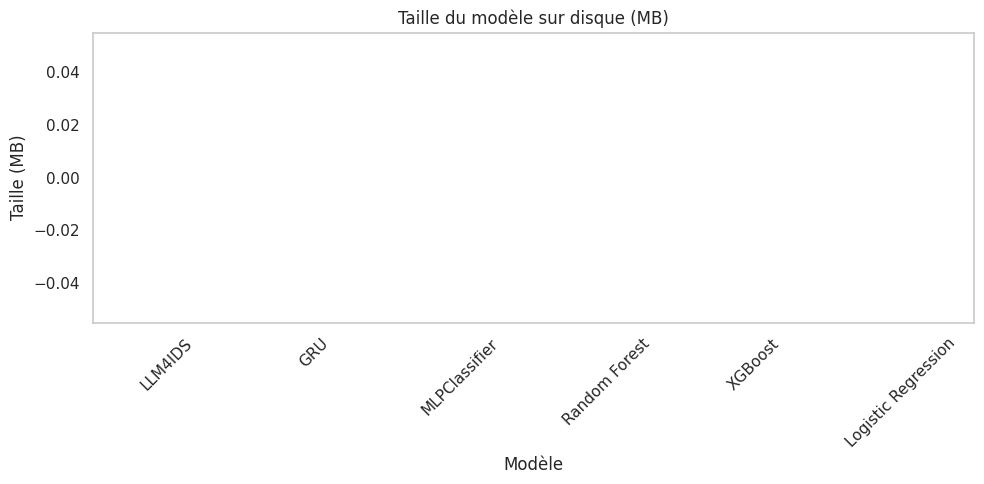

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Accuracy
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="Accuracy", data=df_scores, palette="viridis")
plt.title("Accuracy (%) par modèle")
plt.ylim(0, 105)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 2. F1-score
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="F1-score", data=df_scores, palette="magma")
plt.title("F1-score (%) par modèle")
plt.ylim(0, 105)
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 3. Temps d'inférence
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="Temps inf. (ms/ex)", data=df_scores, palette="crest")
plt.title("Temps d'inférence moyen (ms/échantillon)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# 4. Taille du modèle
plt.figure(figsize=(10, 5))
sns.barplot(x="Modèle", y="Taille (MB)", data=df_scores, palette="flare")
plt.title("Taille du modèle sur disque (MB)")
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

def plot_best_model_per_class_roc(models_info, X_test_dict, y_test, le):
    """
    Affiche une courbe ROC par classe, avec le meilleur modèle pour chaque.

    Parameters:
    - models_info : list of dicts with keys:
        - "name": nom du modèle
        - "model": l'objet modèle
        - "keras": True/False
        - "X_test": données d'entrée (correctly shaped for the model)
    - y_test : ground truth (one-hot or int)
    - le : LabelEncoder utilisé
    """

    # 1. Préparation
    if len(y_test.shape) > 1:
        y_true = np.argmax(y_test, axis=1)
    else:
        y_true = y_test

    y_bin = label_binarize(y_true, classes=np.arange(len(le.classes_)))
    best_aucs = [-1] * len(le.classes_)
    best_curves = [None] * len(le.classes_)
    best_models = [""] * len(le.classes_)

    # 2. Pour chaque modèle, calculer les courbes ROC par classe
    for info in models_info:
        name = info["name"]
        model = info["model"]
        keras = info["keras"]
        X = info["X_test"] # Use the pre-shaped X_test from the dictionary

        # Ensure correct shape for Keras models before prediction
        if keras:
            # Check the expected input shape of the Keras model
            input_shape = model.input_shape
            if len(input_shape) == 3 and len(X.shape) == 2:
                 # Add the missing dimension if needed (e.g., for GRU/Transformer)
                 X_shaped = np.expand_dims(X, axis=1)
            elif len(input_shape) == 3 and len(X.shape) == 3 and input_shape[2] == 1 and X.shape[2] != 1:
                 # Reshape if the feature dimension is missing but time step/channel is present (e.g., for CNN)
                 X_shaped = np.expand_dims(X, axis=2)
            else:
                X_shaped = X # Use as is if shapes are compatible

            y_score = model.predict(X_shaped, verbose=0)
        elif hasattr(model, "predict_proba"):
            y_score = model.predict_proba(X)
        else:
            continue

        for i, class_name in enumerate(le.classes_):
            if np.sum(y_bin[:, i]) == 0:
                continue
            fpr, tpr, _ = roc_curve(y_bin[:, i], y_score[:, i])
            auc = roc_auc_score(y_bin[:, i], y_score[:, i])

            if auc > best_aucs[i]:
                best_aucs[i] = auc
                best_curves[i] = (fpr, tpr)
                best_models[i] = name

    # 3. Tracer les meilleures courbes par classe
    plt.figure(figsize=(10, 7))
    for i, class_name in enumerate(le.classes_):
        if best_curves[i] is not None:
            fpr, tpr = best_curves[i]
            auc = best_aucs[i]
            plt.plot(fpr, tpr, label=f"{class_name} (AUC={auc:.2f}, {best_models[i]})")

    plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
    plt.title("Courbe ROC - Meilleur modèle par classe")
    plt.xlabel("Faux positifs (FPR)")
    plt.ylabel("Vrais positifs (TPR)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 22 variables whereas the saved optimizer has 42 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


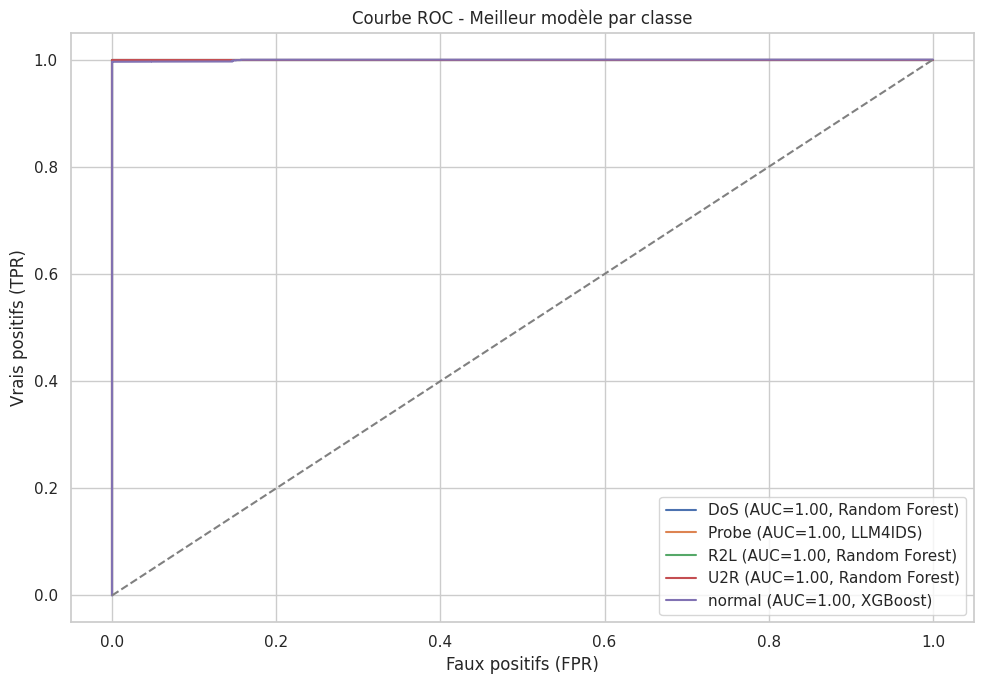

In [ ]:
from tensorflow.keras.models import load_model
import joblib

models_info = [
    {
        "name": "LLM4IDS",
        "model": load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/Mod_Multi/llm4ids_multiclass_nslkdd2.keras"),
        "keras": True,
        "X_test": X_test_tf
    },
    {
        "name": "CNN",
        "model": load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/cnn_multiclass.keras"),
        "keras": True,
        "X_test": X_test_cnn
    },
    {
        "name": "MLP",
        "model": joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/mlp_sklearn_llm4ids.pkl"),
        "keras": False,
        "X_test": X_test_comb
    },
    {
        "name": "Random Forest",
        "model": joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/random_forest_llm4ids.pkl"),
        "keras": False,
        "X_test": X_test_comb
    },
    {
        "name": "XGBoost",
        "model": joblib.load("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/xgb_llm4ids_model.pkl"),
        "keras": False,
        "X_test": X_test_comb
    },
    {
        "name": "GRU",
        "model": load_model("/content/drive/MyDrive/LLM4IDS/LLM4-IDS/nsl-kdd/models/gru_multiclass.keras"),
        "keras": True,
        "X_test": X_test
    }
]

# y_test_enc = one-hot ou y_test = int selon ton code
plot_best_model_per_class_roc(models_info, X_test_dict=None, y_test=y_test_enc, le=le)

### Interpretability

In [ ]:
!pip install ipywidgets
!jupyter nbextension enable --py widgetsnbextension



In [ ]:
import ipywidgets as widgets
from IPython.display import display
import matplotlib.pyplot as plt
import seaborn as sns

# Dropdown pour choisir un modèle
model_selector = widgets.Dropdown(
    options=metrics_df["Modèle"].tolist(),
    description='Modèle:',
    style={'description_width': 'initial'}
)

# Fonction pour afficher les scores du modèle sélectionné
def plot_model_metrics(model_name):
    row = metrics_df[metrics_df["Modèle"] == model_name].iloc[0]
    scores = row[["Accuracy", "Precision", "Recall", "F1-score"]]

    plt.figure(figsize=(6, 4))
    sns.barplot(x=scores.index, y=scores.values, palette="viridis")
    plt.title(f"Performance du modèle : {model_name}")
    plt.ylim(0, 1.1)
    plt.grid(axis='y')
    plt.tight_layout()
    plt.show()

# Lier l’interactivité
interactive_plot = widgets.interactive_output(
    plot_model_metrics,
    {'model_name': model_selector}
)

# Affichage du tableau de bord
display(widgets.VBox([model_selector, interactive_plot]))


In [ ]:
pip install shap


In [ ]:
pip install lime


In [ ]:
from lime import lime_tabular
import numpy as np

X_train_tf = np.expand_dims(X_train_comb, axis=1)
X_val_tf = np.expand_dims(X_val_comb, axis=1)
X_test_tf = np.expand_dims(X_test_comb, axis=1)
# Important : on retire les dimensions inutiles (LLM4IDS = (n, 1, features))
X_lime = X_test_tf[:, 0, :]  # (n_samples, n_features)

# 1. Créer l’explainer
explainer = lime_tabular.LimeTabularExplainer(
    training_data=X_lime,
    mode='classification',
    feature_names=[f"f{i}" for i in range(X_lime.shape[1])],
    class_names=le.classes_,  # par ex. ['Normal', 'DoS', 'Probe', 'R2L', 'U2R']
    discretize_continuous=True
)

# 2. Choisir une instance à expliquer
i = 42  # indice à expliquer
instance = X_lime[i]

# 3. Fonction prédictive adaptée pour LIME
def predict_fn_lime(data):
    data_reshaped = data.reshape((data.shape[0], 1, data.shape[1]))  # (batch, 1, features)
    return llm4ids_model.predict(data_reshaped)

# 4. Explication
exp = explainer.explain_instance(instance, predict_fn_lime, num_features=10)

# 5. Affichage
exp.show_in_notebook(show_table=True, show_all=False)


157/157 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step


In [ ]:
!pip install lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=5a88eebbc9fe285aee30ef1ad10a0da47bd1a6c7150abfcc3ab3afd970abe541
  Stored in directory: /root/.cache/pip/wheels/85/fa/a3/9c2d44c9f3cd77cf4e533b58900b2bf4487f2a17e8ec212a3d
Successfully built lime
